### Zadanie: porównanie metod klasteringu

Zajmiemy zbiorem danych z telefonów Samsung, dotyczących aktywności fizycznej.

Dane są zebrane w pliku Samsung_HAR.zip. Należy je rozpakować i przeanalizować.

Obróbka danych wejściowych:

Czy potrzeba wszystkich cech?

Czy potrzebna jest jakaś obróbka?

Czy wiemy, jak obrobić?

Czy wiemy, co jaka cecha znaczy?

Czy potrzebujemy aż dwóch plików?

Pamiętajmy, że mamy do czynienia z Unsupervised Learning. Czy podział na dane testowe i treningowe jest potrzebny, jeśli tak to dlaczego, jeśli nie to dlaczego?

Do zrobienia:

Użyj poznanych metod klasteringu, aby podzielić dany zbiór (pamiętaj o skalowaniu itp.).

Zwizualizuj podział przez każdy algorytm (możesz użyć metod z notatników).

Z jakim typem czynności algorytmy poradziły sobie super, z jakim nie najlepiej. Typy czynności (dane zawarte w plikach *labels):

1 – marsz

2 – wchodzenie w górę po schodach

3 – schodzenie w dół ze schodów

4 – siedzenie

5 – stanie

6 – leżenie

Dobierz prawidłową ilość klastrów w przypadku metody KMeans.

Na danym zbiorze dokonaj preprocessingu, używając metod klasteringu. Następnie wyszkol dwa wybrane przez siebie klasyfikatory typu Supervised Learning i spróbuj uzyskać jak najlepszy wynik, używając wszystkich znanych sobie "wspomagaczy".

W przypadku użycia train_test_split albo KFold/StratifiedKFold, możemy połączyć zbiory, gdyż i tak wydzielamy zbiór walidacyjny.

Chyba że chcemy mieć dodatkowy zbiór testowy do przetestowania modeli po wyszkoleniu. Chcemy?

Ideą klasteringu jest podział na podgrupy, czyli tutaj oczekujemy, że nasze algorytmy podzielą zbiór na 6 wspomnianych klastrów: marsz, wchodzenie/schodzenie po schodach, siedzenie, stanie, leżenie. Zbadaj, jak są porozrzucane w różnych klastrach. Im bardziej są rozrzucone, tym algorytm gorzej sobie z nimi radzi. Ideałem jest: jeden klaster, jedna czynność.

Na koniec pytanie, na które należy również odpowiedzieć, a które pojawia się zawsze podczas rozmów kwalifikacyjnych:

czym różni się KMeans, K-fold i K Nearest Neighbors (o tym ostatnim trzeba doczytać).
Rozwiązanie prześlij Mentorowi.

### Obróbka danych wejściowych:

Czy potrzeba wszystkich cech? - Nie, tych z bardzo dużymi brakami nie potrzebujemy.

Czy potrzebna jest jakaś obróbka? - Tak, potrzebna jest obróbka danych.

Czy wiemy, jak obrobić? - Tak, muszimy z pliku txt zorbić DF, żeby można je było obrobić. Usunąć należy również kolumny, które mają zbyt mało danych

Czy wiemy, co jaka cecha znaczy? - Nie wiemy, cachy nie mają nagłówków, nie wiemy dlaczego są liczby ujemne.

Czy potrzebujemy aż dwóch plików? - Tak, potrzebujemy dwóch plików train i test, które połączymy, żeby mieć więcej danych.

Pamiętajmy, że mamy do czynienia z Unsupervised Learning. Czy podział na dane testowe i treningowe jest potrzebny, jeśli tak to dlaczego, jeśli nie to dlaczego? - Podział plików na dane testowe i treningowe nie jest potrzebny, ponieważ w Unsupervised Learning nie ma nauczyciela


In [514]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

In [515]:
data_train = open('samsung_train.txt')
data_test = open('samsung_test.txt')
linie_train=data_train.readlines()
linie_test=data_test.readlines()

print('liczba wierszy w pliku train={}'.format(len(linie_train)))
print('liczba wierszy w pliku test={}'.format(len(linie_test)))

liczba wierszy w pliku train=7352
liczba wierszy w pliku test=2947


In [516]:
with open('samsung_train.txt') as temp_f:
    col_count = [ len(l.split(" ")) for l in temp_f.readlines() ]

column_names = [i for i in range(max(col_count))] 

data_train = pd.read_csv('samsung_train.txt', sep=' ', header = None, names=column_names )
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,924,925,926,927,928,929,930,931,932,933
0,NaN,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [517]:
with open('samsung_test.txt') as temp_f:
    col_count = [ len(l.split(" ")) for l in temp_f.readlines() ]

column_names = [i for i in range(max(col_count))] 

data_test = pd.read_csv('samsung_test.txt', sep=' ', header = None, names=column_names )
data_test.head()

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,NaN,NaN,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [518]:
data = pd.concat([data_train, data_test])
data.head()

,0,1,2,3,4,5,6,7,8,9,...,924,925,926,927,928,929,930,931,932,933
0,NaN,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [519]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10299 entries, 0 to 2946
Columns: 934 entries, 0 to 933
dtypes: float64(934)
memory usage: 73.5 MB


<AxesSubplot: >

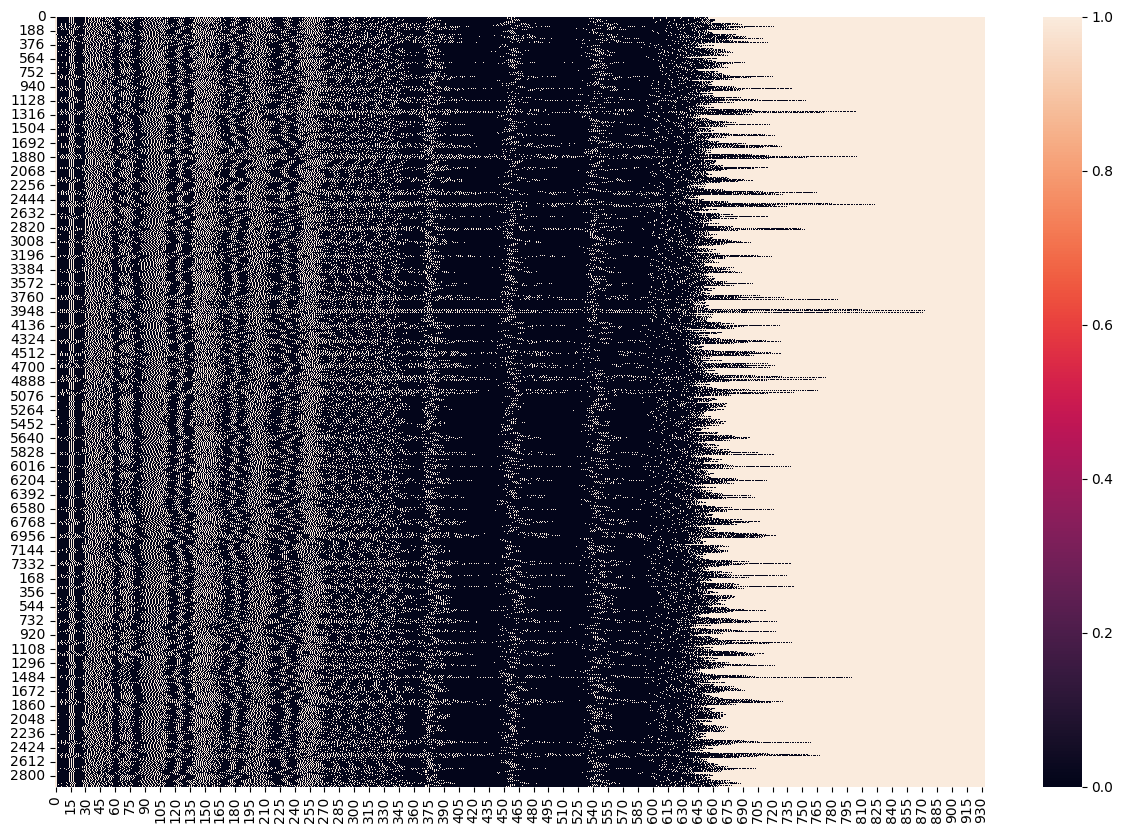

In [520]:
plt.figure(figsize=(15,10))
sns.heatmap(data.isnull())

In [521]:
data.drop_duplicates(inplace=True)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,924,925,926,927,928,929,930,931,932,933
0,NaN,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [522]:
data.dropna(thresh=1, axis=1, inplace=True)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,920,921,922,923,924,926,928,929,931,933
0,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [523]:
data.dropna(thresh=1, inplace=True)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,920,921,922,923,924,926,928,929,931,933
0,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [524]:
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)
data.columns = range(data.columns.size)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,912,913,914,915,916,917,918,919,920,921
0,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: >

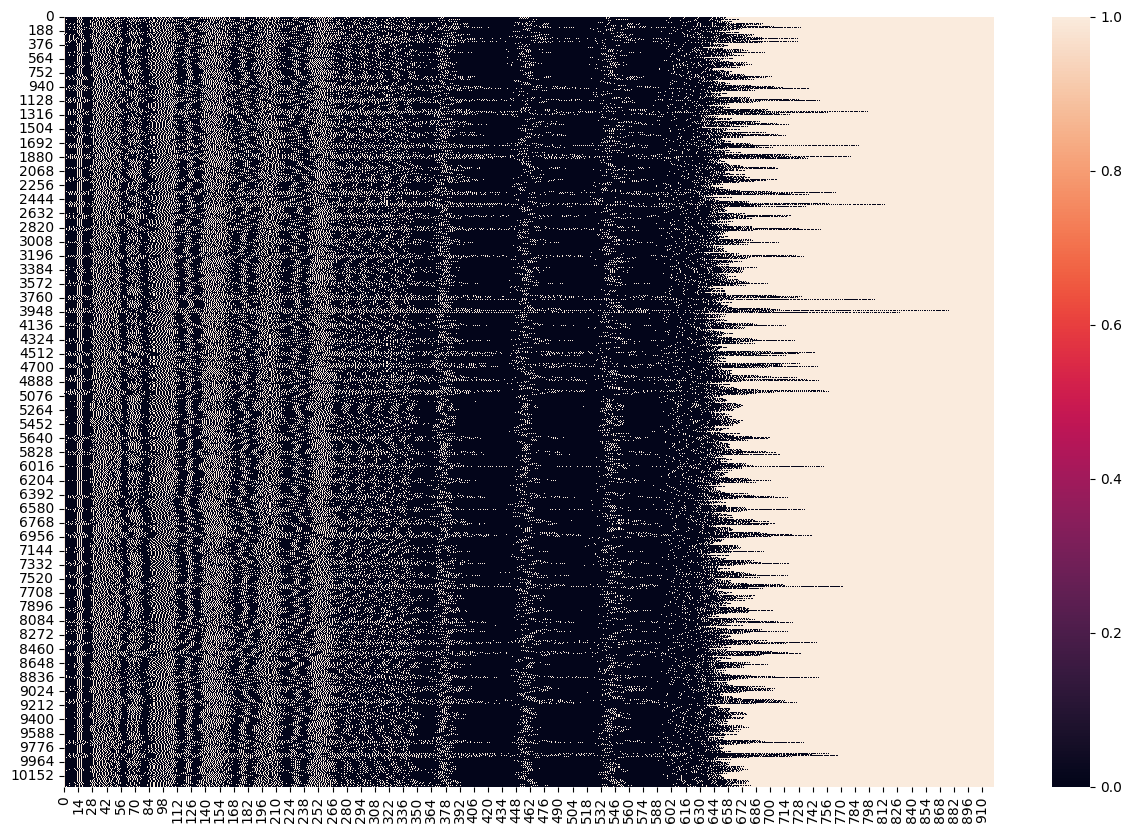

In [525]:
plt.figure(figsize=(15,10))
sns.heatmap(data.isnull())

In [526]:
data.fillna(0, inplace=True)

In [527]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 922 entries, 0 to 921
dtypes: float64(922)
memory usage: 72.4 MB


<AxesSubplot: >

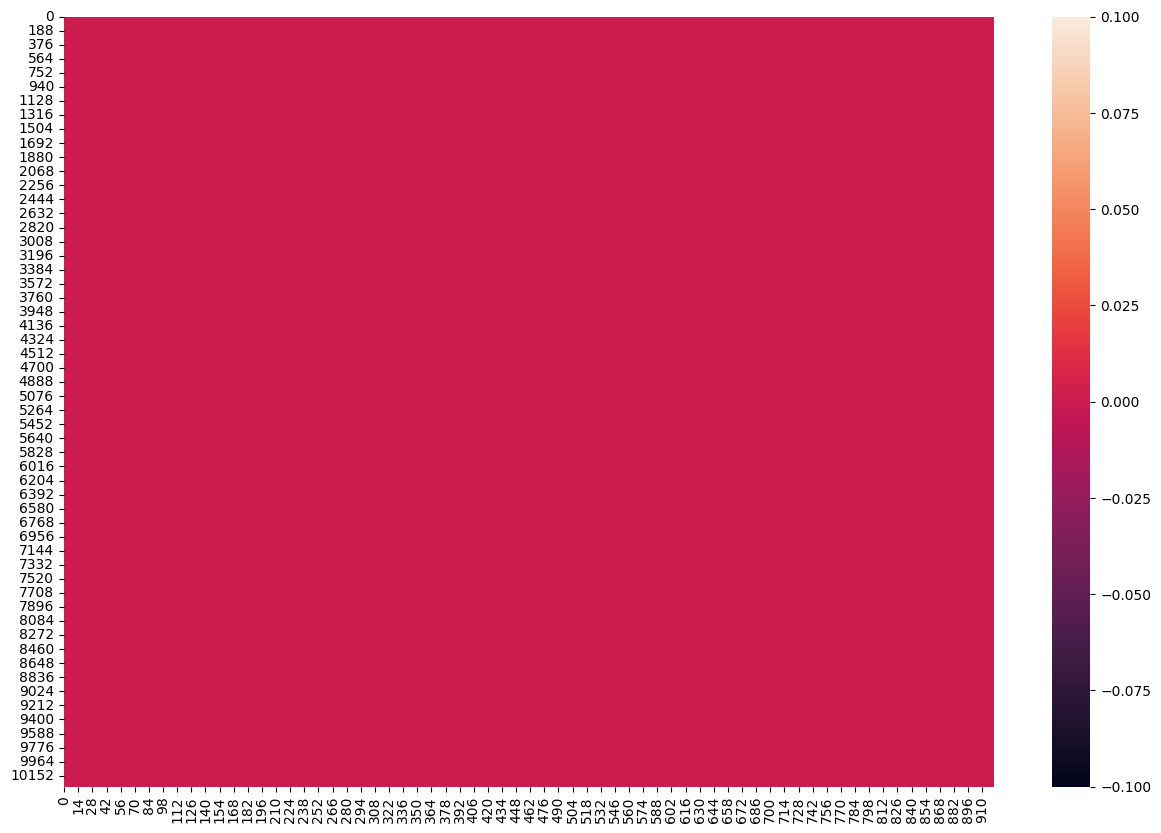

In [528]:
plt.figure(figsize=(15,10))
sns.heatmap(data.isnull())

In [529]:
# from sklearn.cluster import KMeans

In [530]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X = data
# X = scaler.fit_transform(X)

In [531]:
# X_train = data_train
# num_features = data.columns

# # przygotowanie wartości numerycznych
# num_preparation = Pipeline(steps=[
#     ('fill_missings', SimpleImputer(strategy='mean')),
#     ('scaler_1', StandardScaler()),
#     ('pca', PCA(n_components=0.85)),
#     ('scaler_2', StandardScaler())])

# # transformer = wartości numeryczne oraz kategoryczne
# data_preparation = ColumnTransformer(transformers=[
#     ('numeric_preprocessing', num_preparation, num_features)])

# model_pipeline = Pipeline(steps=[('preprocessor', data_preparation),
#                                     ('model', KMeans(n_clusters=6))])
# model_pipeline.fit(X_train)

In [532]:
# params = {'preprocessor__numeric_preprocessing__fill_missings__strategy': ['mean', 'median'],
# 'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.95, 0.99]}

In [533]:
# grid_search = GridSearchCV(model_pipeline, params, scoring='f1_macro')
# grid_search.fit(X)
# print('Wybrane hiperparametry: ', grid_search.best_params_)
# model_kmeans = grid_search.best_estimator_

In [534]:
# data.fillna(data_train.mean(), inplace=True)

In [535]:
# print(data.isnull())

In [536]:
# plt.figure(figsize=(15,10))
# sns.heatmap(data.isnull())

In [537]:
# data.drop(0, axis=1, inplace=True)
# data.columns = range(data.columns.size)

In [538]:
# data.info()

In [539]:
# plt.figure(figsize=(15,10))
# sns.heatmap(data.isnull())

In [540]:
labels_train = open('samsung_train_labels.txt')
labels_test = open('samsung_test_labels.txt')
linie_train=labels_train.readlines()
linie_test=labels_test.readlines()

print('liczba wierszy w pliku train={}'.format(len(linie_train)))
print('liczba wierszy w pliku test={}'.format(len(linie_test)))

liczba wierszy w pliku train=7352
liczba wierszy w pliku test=2947


In [541]:
labels_train = pd.read_csv('samsung_train_labels.txt', header = None)
labels_train.head()

,0
0,5
1,5
2,5
3,5
4,5


In [542]:
labels_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       7352 non-null   int64
dtypes: int64(1)
memory usage: 57.6 KB


In [543]:
labels_test = pd.read_csv('samsung_test_labels.txt', header = None)
labels_test.head()

,0
0,5
1,5
2,5
3,5
4,5


In [544]:
labels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       2947 non-null   int64
dtypes: int64(1)
memory usage: 23.1 KB


In [545]:
labels_train.columns = ['target']
labels_test.columns = ['target']
target = pd.concat([labels_train, labels_test])
target.head()

,target
0,5
1,5
2,5
3,5
4,5


In [546]:
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10299 entries, 0 to 2946
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  10299 non-null  int64
dtypes: int64(1)
memory usage: 160.9 KB


In [547]:
target.reset_index(inplace=True)
target.drop(['index'], axis=1, inplace=True)
target.head()

,target
0,5
1,5
2,5
3,5
4,5


In [548]:
dataset=pd.concat([data, target], axis=1)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,913,914,915,916,917,918,919,920,921,target
0,0.0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,0.0,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,0.0,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.0,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [549]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 923 entries, 0 to target
dtypes: float64(922), int64(1)
memory usage: 72.5 MB


In [550]:
dataset.reset_index(inplace=True)
dataset.drop(['index'], axis=1, inplace=True)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,913,914,915,916,917,918,919,920,921,target
0,0.0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,0.0,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
3,0.0,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.0,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [551]:
from pandas import RangeIndex
# columns = []
# for i in RangeIndex(start=0, stop=922, step=1):
#     columns.append(i)
columns = RangeIndex(start=0, stop=923, step=1)
X, y = dataset[columns], dataset['target']
print('X:')
display(X)
print('\ny:')
display(y)

KeyError: '[922] not in index'

In [ ]:
print(X.index)

AttributeError: 'RangeIndex' object has no attribute 'index'

In [ ]:
import numpy as np

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()

kf = KFold(n_splits=5, shuffle=True, random_state=1)

models = []
scores = []

for fold_nr, (train_idx, test_idx) in enumerate(kf.split(X)):
  X_train = X[train_idx]
  X_test =X[test_idx]

  y_train = y[train_idx]
  y_test = y[test_idx]

  # skalowanie danych wejściowych, aby model lepiej działał
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  clf = SGDClassifier(random_state=1).fit(X_train, y_train)

  models.append(clf)
  scores.append(clf.score(X_test, y_test))


print("wyniki poszczególnych foldów: ", scores)
print("średni wynik wszystkich foldów: ", np.array(scores).mean())

KeyError: '[924, 925, 926, 927, 928, 930, 933, 934, 935, 936, 937, 938, 940, 942, 943, 944, 945, 947, 948, 949, 950, 951, 952, 953, 955, 957, 958, 960, 962, 963, 965, 966, 967, 968, 969, 971, 972, 973, 974, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 989, 990, 991, 992, 993, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1006, 1007, 1008, 1009, 1010, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1035, 1036, 1037, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1061, 1062, 1064, 1065, 1066, 1067, 1068, 1069, 1071, 1072, 1074, 1075, 1076, 1077, 1079, 1080, 1081, 1082, 1083, 1084, 1086, 1087, 1088, 1089, 1090, 1092, 1093, 1095, 1096, 1097, 1099, 1100, 1101, 1102, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1115, 1116, 1118, 1119, 1120, 1121, 1127, 1128, 1129, 1130, 1131, 1133, 1134, 1135, 1136, 1137, 1138, 1142, 1143, 1146, 1147, 1149, 1150, 1151, 1152, 1153, 1155, 1157, 1158, 1161, 1162, 1164, 1166, 1169, 1171, 1174, 1175, 1176, 1179, 1180, 1181, 1182, 1184, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1218, 1219, 1220, 1221, 1222, 1223, 1224, 1226, 1227, 1229, 1230, 1231, 1232, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258, 1259, 1261, 1263, 1265, 1267, 1268, 1269, 1270, 1272, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1283, 1284, 1285, 1286, 1287, 1290, 1291, 1294, 1295, 1296, 1298, 1301, 1302, 1303, 1304, 1306, 1309, 1310, 1311, 1313, 1314, 1316, 1317, 1318, 1319, 1320, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1333, 1334, 1335, 1336, 1337, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1357, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1405, 1407, 1408, 1409, 1411, 1412, 1413, 1414, 1415, 1417, 1418, 1419, 1420, 1421, 1423, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1434, 1436, 1438, 1439, 1440, 1441, 1442, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1459, 1460, 1461, 1464, 1465, 1466, 1467, 1468, 1469, 1471, 1472, 1473, 1474, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1489, 1490, 1491, 1492, 1493, 1495, 1496, 1497, 1498, 1500, 1502, 1503, 1504, 1505, 1506, 1507, 1509, 1511, 1512, 1514, 1516, 1517, 1519, 1521, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1534, 1535, 1538, 1539, 1541, 1542, 1543, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1556, 1557, 1558, 1559, 1560, 1561, 1563, 1564, 1565, 1566, 1567, 1568, 1569, 1570, 1573, 1574, 1575, 1577, 1578, 1579, 1580, 1581, 1582, 1584, 1585, 1586, 1587, 1588, 1590, 1591, 1592, 1593, 1594, 1596, 1597, 1598, 1599, 1602, 1603, 1604, 1605, 1606, 1607, 1609, 1610, 1611, 1612, 1613, 1614, 1616, 1617, 1618, 1619, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1629, 1630, 1631, 1632, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1647, 1648, 1649, 1650, 1651, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1662, 1663, 1664, 1665, 1666, 1667, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1704, 1705, 1706, 1707, 1708, 1709, 1712, 1713, 1714, 1715, 1716, 1717, 1719, 1721, 1722, 1724, 1725, 1726, 1727, 1728, 1730, 1733, 1734, 1736, 1737, 1738, 1739, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1751, 1752, 1753, 1754, 1757, 1758, 1760, 1761, 1762, 1763, 1765, 1766, 1767, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1778, 1779, 1780, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1791, 1792, 1793, 1794, 1795, 1796, 1798, 1799, 1800, 1801, 1802, 1803, 1805, 1807, 1808, 1809, 1810, 1811, 1813, 1815, 1816, 1817, 1818, 1819, 1821, 1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834, 1835, 1836, 1837, 1838, 1839, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1848, 1849, 1850, 1852, 1853, 1854, 1855, 1856, 1857, 1858, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1869, 1870, 1871, 1872, 1874, 1875, 1876, 1877, 1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1891, 1892, 1894, 1895, 1896, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1913, 1914, 1916, 1918, 1919, 1920, 1921, 1922, 1923, 1926, 1927, 1928, 1929, 1931, 1932, 1934, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1948, 1949, 1950, 1951, 1952, 1954, 1955, 1957, 1959, 1960, 1962, 1963, 1964, 1965, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1985, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2019, 2020, 2022, 2023, 2024, 2025, 2026, 2027, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2040, 2042, 2043, 2044, 2045, 2046, 2047, 2049, 2050, 2055, 2056, 2057, 2058, 2059, 2060, 2062, 2063, 2064, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2079, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2091, 2092, 2094, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2104, 2105, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2117, 2118, 2119, 2120, 2121, 2124, 2125, 2126, 2127, 2129, 2130, 2131, 2132, 2133, 2135, 2136, 2137, 2138, 2139, 2141, 2142, 2143, 2145, 2146, 2147, 2148, 2149, 2150, 2152, 2153, 2154, 2155, 2156, 2160, 2162, 2163, 2164, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2183, 2184, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2197, 2198, 2199, 2200, 2203, 2204, 2207, 2208, 2210, 2211, 2212, 2214, 2216, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2244, 2246, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2258, 2259, 2260, 2261, 2263, 2264, 2265, 2266, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2283, 2284, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2295, 2297, 2299, 2300, 2301, 2302, 2303, 2304, 2306, 2307, 2308, 2309, 2310, 2312, 2313, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2329, 2330, 2332, 2334, 2335, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2363, 2365, 2366, 2368, 2369, 2371, 2374, 2375, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2386, 2387, 2388, 2389, 2390, 2392, 2393, 2395, 2396, 2399, 2401, 2402, 2405, 2406, 2408, 2409, 2410, 2411, 2412, 2413, 2415, 2417, 2419, 2420, 2421, 2424, 2425, 2426, 2427, 2428, 2429, 2431, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2444, 2446, 2447, 2448, 2449, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2460, 2461, 2462, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477, 2478, 2479, 2480, 2482, 2483, 2484, 2485, 2486, 2487, 2491, 2493, 2494, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510, 2511, 2513, 2514, 2515, 2516, 2518, 2520, 2521, 2522, 2523, 2525, 2526, 2527, 2528, 2529, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2538, 2539, 2540, 2541, 2542, 2543, 2544, 2545, 2546, 2547, 2548, 2550, 2551, 2552, 2553, 2554, 2555, 2557, 2558, 2559, 2561, 2564, 2565, 2566, 2568, 2569, 2570, 2572, 2573, 2575, 2576, 2577, 2578, 2579, 2581, 2582, 2584, 2585, 2586, 2587, 2588, 2589, 2591, 2592, 2593, 2594, 2595, 2596, 2599, 2600, 2601, 2602, 2603, 2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2614, 2616, 2618, 2622, 2623, 2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636, 2637, 2638, 2640, 2642, 2643, 2644, 2645, 2647, 2648, 2650, 2651, 2654, 2655, 2656, 2658, 2659, 2660, 2662, 2664, 2665, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2677, 2678, 2679, 2681, 2682, 2683, 2684, 2685, 2686, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2703, 2704, 2705, 2707, 2708, 2709, 2710, 2712, 2713, 2714, 2715, 2716, 2718, 2719, 2720, 2721, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2731, 2732, 2734, 2735, 2736, 2737, 2738, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2765, 2766, 2767, 2769, 2771, 2774, 2775, 2777, 2778, 2779, 2781, 2782, 2783, 2784, 2786, 2787, 2788, 2789, 2791, 2792, 2794, 2796, 2797, 2798, 2799, 2800, 2801, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2834, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2843, 2845, 2846, 2847, 2848, 2849, 2850, 2851, 2852, 2853, 2855, 2857, 2859, 2860, 2861, 2862, 2863, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2876, 2877, 2879, 2880, 2881, 2882, 2883, 2884, 2886, 2887, 2889, 2890, 2891, 2892, 2893, 2895, 2896, 2897, 2898, 2902, 2903, 2904, 2905, 2906, 2909, 2910, 2911, 2913, 2914, 2916, 2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928, 2929, 2930, 2931, 2935, 2936, 2937, 2938, 2940, 2941, 2944, 2945, 2946, 2948, 2949, 2950, 2952, 2953, 2955, 2956, 2957, 2959, 2960, 2961, 2962, 2963, 2964, 2966, 2967, 2968, 2969, 2970, 2971, 2972, 2974, 2977, 2979, 2980, 2984, 2986, 2988, 2990, 2991, 2992, 2993, 2994, 2995, 2996, 2997, 2998, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3012, 3013, 3014, 3015, 3017, 3018, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3058, 3059, 3060, 3061, 3062, 3066, 3070, 3071, 3072, 3073, 3074, 3075, 3076, 3077, 3078, 3079, 3080, 3082, 3083, 3084, 3087, 3088, 3089, 3090, 3091, 3093, 3094, 3096, 3098, 3099, 3100, 3101, 3102, 3103, 3104, 3105, 3106, 3108, 3109, 3110, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 3120, 3121, 3122, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3133, 3134, 3135, 3136, 3137, 3138, 3139, 3140, 3141, 3142, 3143, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3189, 3190, 3192, 3193, 3194, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 3220, 3221, 3222, 3223, 3225, 3226, 3227, 3228, 3229, 3230, 3232, 3233, 3234, 3235, 3236, 3237, 3238, 3239, 3240, 3241, 3242, 3243, 3244, 3245, 3246, 3247, 3248, 3250, 3251, 3252, 3254, 3255, 3256, 3257, 3258, 3259, 3260, 3261, 3263, 3264, 3266, 3267, 3268, 3269, 3270, 3271, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3280, 3281, 3282, 3283, 3284, 3285, 3286, 3287, 3288, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3297, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3313, 3314, 3316, 3317, 3318, 3319, 3320, 3321, 3323, 3324, 3325, 3326, 3327, 3328, 3329, 3330, 3331, 3333, 3334, 3336, 3337, 3338, 3339, 3340, 3341, 3343, 3344, 3345, 3346, 3348, 3349, 3351, 3352, 3355, 3356, 3358, 3359, 3360, 3362, 3364, 3365, 3366, 3367, 3369, 3371, 3372, 3375, 3376, 3377, 3378, 3379, 3381, 3383, 3385, 3386, 3387, 3388, 3389, 3390, 3391, 3392, 3394, 3395, 3398, 3400, 3401, 3402, 3403, 3405, 3408, 3409, 3410, 3411, 3412, 3413, 3414, 3415, 3416, 3417, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3428, 3429, 3430, 3431, 3432, 3434, 3436, 3437, 3438, 3439, 3440, 3441, 3442, 3443, 3444, 3445, 3446, 3447, 3449, 3450, 3451, 3452, 3453, 3454, 3455, 3456, 3457, 3458, 3459, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3469, 3470, 3471, 3473, 3477, 3478, 3479, 3480, 3482, 3483, 3486, 3487, 3488, 3489, 3490, 3492, 3494, 3495, 3499, 3500, 3501, 3502, 3503, 3504, 3505, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3517, 3518, 3519, 3520, 3522, 3523, 3524, 3525, 3527, 3528, 3529, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539, 3540, 3541, 3542, 3543, 3544, 3545, 3546, 3547, 3548, 3549, 3550, 3551, 3552, 3553, 3554, 3555, 3556, 3557, 3558, 3559, 3560, 3561, 3562, 3564, 3565, 3566, 3567, 3569, 3572, 3573, 3574, 3575, 3577, 3578, 3579, 3580, 3581, 3582, 3584, 3586, 3587, 3588, 3589, 3590, 3591, 3593, 3594, 3595, 3596, 3598, 3599, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3613, 3615, 3616, 3617, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3629, 3630, 3631, 3633, 3634, 3635, 3636, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3646, 3647, 3648, 3650, 3651, 3652, 3653, 3654, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3668, 3669, 3670, 3671, 3672, 3673, 3674, 3675, 3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685, 3686, 3691, 3692, 3693, 3694, 3695, 3696, 3697, 3698, 3699, 3700, 3701, 3702, 3703, 3704, 3706, 3707, 3709, 3710, 3711, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3719, 3720, 3721, 3722, 3723, 3724, 3725, 3726, 3727, 3728, 3729, 3730, 3734, 3735, 3736, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3771, 3772, 3773, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3799, 3800, 3801, 3803, 3804, 3805, 3806, 3807, 3808, 3811, 3812, 3814, 3816, 3819, 3820, 3823, 3824, 3825, 3826, 3827, 3828, 3830, 3832, 3834, 3837, 3838, 3843, 3844, 3845, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3861, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 3877, 3878, 3879, 3880, 3883, 3884, 3885, 3886, 3887, 3888, 3889, 3890, 3891, 3892, 3893, 3895, 3896, 3898, 3899, 3900, 3901, 3902, 3903, 3904, 3905, 3906, 3908, 3910, 3911, 3912, 3913, 3914, 3915, 3916, 3917, 3918, 3920, 3921, 3922, 3923, 3924, 3926, 3927, 3930, 3931, 3932, 3934, 3935, 3936, 3938, 3939, 3940, 3941, 3944, 3945, 3946, 3947, 3948, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3962, 3963, 3964, 3965, 3966, 3967, 3968, 3969, 3970, 3971, 3972, 3973, 3974, 3975, 3976, 3977, 3978, 3981, 3982, 3983, 3984, 3985, 3987, 3988, 3991, 3992, 3994, 3995, 3996, 3997, 3999, 4000, 4001, 4002, 4004, 4005, 4007, 4010, 4011, 4012, 4013, 4014, 4018, 4020, 4021, 4022, 4023, 4024, 4025, 4026, 4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4037, 4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4047, 4048, 4049, 4051, 4052, 4054, 4055, 4056, 4058, 4059, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4070, 4071, 4072, 4073, 4074, 4075, 4076, 4078, 4080, 4081, 4082, 4083, 4085, 4086, 4087, 4088, 4089, 4091, 4093, 4094, 4095, 4098, 4099, 4100, 4101, 4102, 4103, 4105, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114, 4115, 4116, 4118, 4119, 4121, 4122, 4123, 4124, 4125, 4126, 4127, 4128, 4129, 4130, 4131, 4132, 4134, 4135, 4136, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4149, 4150, 4152, 4153, 4155, 4156, 4157, 4158, 4159, 4160, 4162, 4163, 4164, 4165, 4168, 4169, 4170, 4171, 4172, 4174, 4176, 4177, 4179, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4190, 4191, 4193, 4195, 4196, 4198, 4199, 4201, 4202, 4203, 4204, 4205, 4206, 4207, 4208, 4210, 4212, 4213, 4214, 4216, 4217, 4218, 4220, 4222, 4224, 4225, 4226, 4229, 4230, 4231, 4232, 4233, 4234, 4235, 4236, 4237, 4238, 4240, 4241, 4242, 4244, 4247, 4248, 4249, 4251, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4260, 4261, 4262, 4263, 4265, 4266, 4267, 4269, 4270, 4271, 4272, 4273, 4274, 4275, 4277, 4278, 4279, 4281, 4283, 4286, 4287, 4289, 4291, 4292, 4293, 4294, 4295, 4296, 4297, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4313, 4314, 4316, 4317, 4318, 4319, 4321, 4323, 4324, 4325, 4327, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4336, 4337, 4338, 4339, 4340, 4341, 4342, 4343, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4353, 4356, 4357, 4358, 4359, 4360, 4361, 4366, 4367, 4368, 4371, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4380, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4391, 4392, 4393, 4394, 4397, 4398, 4399, 4400, 4401, 4402, 4403, 4404, 4405, 4406, 4407, 4408, 4409, 4411, 4412, 4413, 4414, 4415, 4416, 4418, 4419, 4420, 4421, 4422, 4425, 4428, 4429, 4430, 4431, 4432, 4433, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4444, 4445, 4446, 4447, 4449, 4450, 4452, 4453, 4454, 4455, 4456, 4457, 4458, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4476, 4478, 4479, 4480, 4481, 4483, 4485, 4486, 4489, 4491, 4492, 4493, 4494, 4495, 4496, 4499, 4500, 4501, 4502, 4505, 4507, 4508, 4509, 4510, 4513, 4515, 4517, 4518, 4520, 4521, 4523, 4524, 4525, 4526, 4527, 4529, 4531, 4532, 4533, 4534, 4536, 4538, 4539, 4541, 4542, 4543, 4545, 4547, 4548, 4550, 4551, 4552, 4553, 4554, 4556, 4557, 4559, 4560, 4561, 4562, 4563, 4564, 4565, 4566, 4567, 4568, 4569, 4570, 4571, 4572, 4573, 4574, 4575, 4577, 4578, 4579, 4580, 4581, 4583, 4584, 4585, 4587, 4588, 4589, 4590, 4591, 4594, 4595, 4596, 4598, 4599, 4601, 4602, 4603, 4605, 4607, 4608, 4609, 4610, 4612, 4613, 4614, 4615, 4616, 4617, 4618, 4619, 4621, 4622, 4623, 4624, 4626, 4627, 4628, 4629, 4630, 4631, 4632, 4633, 4635, 4637, 4638, 4639, 4642, 4644, 4645, 4646, 4647, 4648, 4650, 4652, 4653, 4654, 4655, 4657, 4658, 4659, 4660, 4661, 4662, 4664, 4665, 4666, 4667, 4668, 4669, 4670, 4671, 4672, 4673, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4684, 4686, 4687, 4689, 4690, 4691, 4692, 4693, 4694, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4705, 4706, 4707, 4708, 4709, 4710, 4711, 4712, 4713, 4714, 4715, 4716, 4717, 4718, 4719, 4720, 4721, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729, 4731, 4732, 4733, 4734, 4735, 4737, 4739, 4740, 4741, 4742, 4743, 4744, 4745, 4746, 4747, 4748, 4749, 4750, 4751, 4752, 4753, 4754, 4755, 4756, 4757, 4758, 4759, 4760, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4769, 4771, 4773, 4775, 4776, 4777, 4779, 4780, 4782, 4785, 4786, 4787, 4788, 4789, 4790, 4791, 4792, 4794, 4795, 4796, 4797, 4798, 4799, 4800, 4801, 4802, 4803, 4804, 4805, 4806, 4807, 4808, 4809, 4810, 4811, 4812, 4813, 4814, 4815, 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4825, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4840, 4841, 4842, 4843, 4844, 4845, 4846, 4847, 4848, 4849, 4850, 4851, 4852, 4853, 4855, 4856, 4858, 4860, 4861, 4863, 4864, 4865, 4866, 4868, 4870, 4871, 4873, 4874, 4875, 4877, 4878, 4879, 4882, 4883, 4884, 4885, 4886, 4887, 4889, 4890, 4891, 4892, 4893, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4903, 4905, 4906, 4907, 4908, 4909, 4910, 4911, 4913, 4914, 4916, 4917, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4929, 4931, 4932, 4933, 4934, 4935, 4937, 4938, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4947, 4949, 4950, 4952, 4954, 4955, 4956, 4957, 4959, 4961, 4962, 4965, 4967, 4969, 4970, 4971, 4972, 4973, 4974, 4975, 4976, 4978, 4979, 4980, 4981, 4982, 4983, 4985, 4986, 4987, 4988, 4990, 4991, 4992, 4994, 4996, 4998, 4999, 5000, 5003, 5004, 5005, 5006, 5007, 5009, 5010, 5011, 5015, 5016, 5017, 5019, 5020, 5021, 5022, 5023, 5024, 5026, 5027, 5028, 5029, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5040, 5041, 5044, 5046, 5047, 5048, 5050, 5051, 5052, 5053, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5066, 5068, 5069, 5070, 5071, 5072, 5073, 5074, 5076, 5077, 5078, 5079, 5080, 5081, 5082, 5083, 5085, 5086, 5087, 5088, 5091, 5092, 5093, 5094, 5095, 5096, 5097, 5098, 5099, 5100, 5101, 5102, 5105, 5106, 5107, 5108, 5109, 5110, 5113, 5115, 5116, 5117, 5120, 5121, 5123, 5132, 5133, 5134, 5135, 5136, 5138, 5140, 5141, 5143, 5145, 5146, 5147, 5148, 5149, 5151, 5153, 5154, 5156, 5158, 5159, 5161, 5162, 5163, 5165, 5166, 5167, 5168, 5169, 5170, 5171, 5172, 5173, 5174, 5175, 5176, 5177, 5178, 5181, 5182, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5192, 5193, 5194, 5195, 5196, 5197, 5199, 5200, 5201, 5203, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5216, 5217, 5219, 5221, 5222, 5223, 5224, 5225, 5226, 5227, 5230, 5232, 5234, 5236, 5237, 5238, 5239, 5240, 5241, 5242, 5244, 5245, 5247, 5248, 5249, 5250, 5251, 5254, 5255, 5256, 5257, 5259, 5260, 5261, 5263, 5264, 5265, 5266, 5267, 5268, 5269, 5270, 5271, 5272, 5273, 5274, 5275, 5276, 5277, 5278, 5279, 5280, 5284, 5285, 5286, 5287, 5288, 5289, 5290, 5291, 5292, 5294, 5295, 5296, 5298, 5299, 5302, 5303, 5304, 5305, 5306, 5308, 5309, 5310, 5311, 5312, 5314, 5315, 5316, 5317, 5318, 5319, 5320, 5322, 5325, 5326, 5327, 5328, 5329, 5330, 5331, 5332, 5333, 5335, 5337, 5340, 5341, 5342, 5343, 5344, 5345, 5346, 5347, 5348, 5349, 5350, 5351, 5352, 5353, 5354, 5355, 5356, 5357, 5358, 5359, 5361, 5363, 5365, 5366, 5367, 5370, 5371, 5372, 5373, 5374, 5375, 5377, 5378, 5379, 5380, 5381, 5382, 5383, 5384, 5386, 5387, 5389, 5390, 5391, 5392, 5394, 5396, 5399, 5400, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5411, 5412, 5413, 5415, 5416, 5418, 5419, 5420, 5421, 5422, 5423, 5425, 5426, 5427, 5428, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5442, 5445, 5446, 5447, 5448, 5449, 5451, 5452, 5453, 5454, 5455, 5456, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5465, 5466, 5467, 5470, 5472, 5473, 5474, 5475, 5476, 5477, 5478, 5479, 5480, 5481, 5482, 5483, 5484, 5486, 5487, 5488, 5490, 5491, 5492, 5494, 5495, 5497, 5498, 5499, 5501, 5502, 5503, 5504, 5506, 5507, 5508, 5509, 5510, 5511, 5512, 5514, 5515, 5516, 5517, 5519, 5520, 5522, 5524, 5526, 5527, 5528, 5529, 5530, 5532, 5533, 5534, 5535, 5536, 5537, 5538, 5540, 5541, 5542, 5543, 5544, 5545, 5546, 5547, 5548, 5549, 5550, 5553, 5554, 5555, 5556, 5557, 5559, 5560, 5561, 5562, 5563, 5564, 5565, 5566, 5567, 5568, 5570, 5572, 5573, 5574, 5575, 5576, 5577, 5578, 5579, 5580, 5581, 5582, 5583, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5593, 5595, 5596, 5597, 5598, 5599, 5601, 5602, 5603, 5605, 5606, 5608, 5609, 5610, 5611, 5612, 5613, 5614, 5615, 5617, 5618, 5619, 5621, 5622, 5623, 5624, 5626, 5627, 5628, 5629, 5630, 5631, 5632, 5634, 5636, 5637, 5639, 5640, 5641, 5642, 5643, 5644, 5646, 5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5656, 5658, 5659, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5669, 5672, 5673, 5674, 5675, 5676, 5677, 5678, 5679, 5680, 5681, 5683, 5684, 5685, 5686, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5695, 5697, 5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5707, 5708, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5724, 5726, 5727, 5728, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5744, 5745, 5750, 5751, 5754, 5756, 5759, 5760, 5762, 5763, 5765, 5766, 5768, 5769, 5770, 5771, 5774, 5776, 5777, 5778, 5779, 5780, 5781, 5782, 5784, 5785, 5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5795, 5796, 5797, 5798, 5799, 5800, 5801, 5802, 5803, 5804, 5805, 5806, 5807, 5809, 5811, 5812, 5813, 5814, 5815, 5817, 5818, 5819, 5820, 5821, 5823, 5824, 5826, 5827, 5828, 5829, 5830, 5831, 5832, 5834, 5835, 5836, 5837, 5839, 5840, 5841, 5842, 5843, 5845, 5846, 5847, 5848, 5849, 5850, 5852, 5854, 5855, 5856, 5858, 5859, 5861, 5864, 5865, 5866, 5867, 5868, 5870, 5872, 5873, 5874, 5875, 5876, 5877, 5879, 5883, 5884, 5885, 5886, 5888, 5889, 5890, 5891, 5892, 5893, 5894, 5895, 5897, 5898, 5899, 5900, 5902, 5904, 5906, 5907, 5908, 5909, 5910, 5911, 5913, 5914, 5915, 5916, 5917, 5918, 5919, 5920, 5922, 5924, 5925, 5926, 5927, 5928, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938, 5939, 5940, 5941, 5942, 5943, 5944, 5945, 5947, 5949, 5950, 5951, 5952, 5953, 5954, 5955, 5956, 5957, 5958, 5960, 5961, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5970, 5971, 5972, 5973, 5974, 5975, 5976, 5977, 5978, 5979, 5981, 5982, 5983, 5984, 5986, 5987, 5988, 5989, 5990, 5991, 5992, 5993, 5994, 5996, 5997, 5998, 5999, 6000, 6001, 6002, 6004, 6006, 6007, 6008, 6009, 6010, 6012, 6013, 6015, 6016, 6017, 6019, 6020, 6021, 6022, 6023, 6025, 6026, 6027, 6028, 6029, 6030, 6031, 6032, 6033, 6035, 6037, 6038, 6039, 6040, 6041, 6044, 6045, 6046, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6058, 6059, 6060, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6071, 6073, 6075, 6076, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6088, 6089, 6090, 6091, 6092, 6093, 6094, 6095, 6096, 6100, 6101, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6113, 6114, 6115, 6116, 6117, 6118, 6119, 6120, 6121, 6122, 6123, 6124, 6125, 6126, 6127, 6128, 6130, 6131, 6135, 6137, 6138, 6139, 6141, 6142, 6143, 6145, 6146, 6147, 6148, 6149, 6151, 6152, 6153, 6154, 6155, 6156, 6157, 6159, 6160, 6161, 6162, 6163, 6165, 6166, 6167, 6168, 6169, 6170, 6171, 6172, 6173, 6174, 6175, 6176, 6177, 6178, 6179, 6180, 6182, 6183, 6184, 6185, 6186, 6187, 6188, 6190, 6191, 6193, 6195, 6196, 6197, 6198, 6199, 6200, 6201, 6204, 6205, 6206, 6208, 6209, 6210, 6211, 6212, 6213, 6214, 6215, 6216, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6228, 6229, 6230, 6231, 6232, 6233, 6234, 6235, 6236, 6237, 6238, 6239, 6241, 6242, 6244, 6245, 6246, 6248, 6249, 6250, 6251, 6252, 6253, 6254, 6257, 6258, 6259, 6261, 6262, 6263, 6264, 6265, 6266, 6269, 6271, 6272, 6273, 6274, 6275, 6277, 6278, 6279, 6281, 6282, 6283, 6284, 6285, 6286, 6288, 6289, 6290, 6291, 6292, 6293, 6294, 6296, 6297, 6298, 6299, 6301, 6302, 6303, 6304, 6305, 6306, 6307, 6308, 6309, 6310, 6311, 6312, 6313, 6314, 6315, 6316, 6317, 6318, 6319, 6321, 6322, 6324, 6325, 6326, 6328, 6329, 6330, 6332, 6334, 6336, 6337, 6338, 6339, 6340, 6341, 6342, 6345, 6346, 6347, 6348, 6350, 6351, 6353, 6354, 6356, 6357, 6358, 6359, 6361, 6362, 6364, 6365, 6366, 6367, 6368, 6369, 6371, 6373, 6375, 6376, 6377, 6378, 6379, 6380, 6382, 6383, 6384, 6386, 6387, 6388, 6389, 6392, 6393, 6394, 6395, 6396, 6397, 6398, 6400, 6401, 6403, 6404, 6406, 6407, 6409, 6412, 6414, 6415, 6417, 6418, 6420, 6421, 6422, 6423, 6424, 6425, 6426, 6427, 6428, 6429, 6430, 6431, 6432, 6435, 6436, 6437, 6438, 6440, 6441, 6443, 6444, 6446, 6448, 6449, 6450, 6451, 6452, 6454, 6455, 6457, 6459, 6460, 6461, 6463, 6464, 6465, 6467, 6468, 6469, 6470, 6471, 6472, 6473, 6476, 6477, 6478, 6479, 6480, 6482, 6483, 6484, 6485, 6486, 6487, 6488, 6489, 6491, 6492, 6493, 6495, 6497, 6498, 6500, 6501, 6502, 6503, 6504, 6505, 6506, 6507, 6508, 6509, 6511, 6512, 6514, 6515, 6516, 6517, 6518, 6519, 6521, 6522, 6524, 6525, 6526, 6527, 6528, 6529, 6530, 6531, 6532, 6533, 6534, 6535, 6538, 6539, 6540, 6541, 6542, 6543, 6544, 6545, 6547, 6548, 6550, 6551, 6552, 6553, 6554, 6555, 6556, 6558, 6560, 6561, 6563, 6564, 6565, 6566, 6567, 6568, 6569, 6570, 6571, 6572, 6574, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583, 6584, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6593, 6594, 6595, 6596, 6597, 6598, 6599, 6601, 6602, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6614, 6615, 6616, 6617, 6618, 6620, 6621, 6622, 6623, 6624, 6626, 6628, 6629, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6650, 6652, 6653, 6655, 6657, 6658, 6659, 6660, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6671, 6672, 6674, 6676, 6677, 6680, 6682, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6697, 6699, 6700, 6701, 6702, 6703, 6704, 6706, 6707, 6709, 6712, 6713, 6714, 6715, 6716, 6718, 6719, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6729, 6730, 6732, 6734, 6735, 6736, 6737, 6738, 6739, 6740, 6742, 6743, 6745, 6746, 6747, 6749, 6750, 6751, 6752, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6768, 6769, 6770, 6771, 6772, 6773, 6774, 6775, 6776, 6777, 6778, 6779, 6780, 6782, 6784, 6785, 6786, 6787, 6788, 6789, 6791, 6792, 6793, 6795, 6796, 6797, 6798, 6799, 6800, 6803, 6806, 6808, 6809, 6810, 6811, 6813, 6814, 6816, 6817, 6818, 6820, 6821, 6822, 6824, 6825, 6826, 6827, 6830, 6831, 6832, 6833, 6834, 6836, 6839, 6840, 6841, 6842, 6843, 6844, 6846, 6848, 6849, 6850, 6851, 6853, 6854, 6856, 6859, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6886, 6888, 6890, 6891, 6893, 6894, 6895, 6896, 6897, 6898, 6899, 6900, 6902, 6903, 6904, 6905, 6906, 6908, 6910, 6911, 6912, 6915, 6916, 6917, 6918, 6919, 6920, 6921, 6922, 6923, 6924, 6925, 6926, 6927, 6929, 6931, 6932, 6933, 6935, 6937, 6938, 6939, 6940, 6941, 6942, 6943, 6944, 6945, 6946, 6947, 6949, 6952, 6953, 6954, 6955, 6959, 6960, 6961, 6962, 6963, 6964, 6965, 6966, 6967, 6969, 6970, 6971, 6972, 6974, 6975, 6976, 6977, 6979, 6980, 6981, 6983, 6984, 6985, 6986, 6989, 6991, 6992, 6994, 6995, 6996, 6997, 6998, 7000, 7002, 7003, 7004, 7006, 7009, 7010, 7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7021, 7022, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7035, 7036, 7037, 7038, 7039, 7040, 7041, 7042, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7054, 7055, 7056, 7057, 7058, 7059, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7076, 7077, 7078, 7080, 7081, 7082, 7083, 7085, 7086, 7087, 7088, 7089, 7090, 7091, 7092, 7093, 7094, 7096, 7097, 7098, 7099, 7100, 7101, 7102, 7103, 7105, 7106, 7108, 7109, 7111, 7112, 7114, 7116, 7118, 7119, 7120, 7121, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7131, 7133, 7134, 7135, 7136, 7139, 7140, 7141, 7143, 7144, 7145, 7147, 7148, 7149, 7150, 7151, 7155, 7157, 7158, 7159, 7160, 7161, 7163, 7165, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7176, 7177, 7178, 7179, 7181, 7182, 7183, 7184, 7185, 7186, 7187, 7190, 7191, 7192, 7193, 7194, 7195, 7196, 7197, 7199, 7200, 7201, 7203, 7204, 7205, 7206, 7207, 7208, 7210, 7211, 7213, 7214, 7215, 7216, 7217, 7218, 7219, 7220, 7221, 7222, 7223, 7224, 7225, 7226, 7227, 7228, 7229, 7230, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7239, 7240, 7241, 7242, 7243, 7244, 7245, 7247, 7249, 7251, 7252, 7253, 7254, 7255, 7256, 7257, 7259, 7261, 7262, 7263, 7264, 7266, 7267, 7271, 7272, 7275, 7277, 7278, 7279, 7280, 7282, 7283, 7284, 7286, 7287, 7288, 7289, 7290, 7291, 7292, 7293, 7294, 7295, 7296, 7297, 7298, 7299, 7300, 7301, 7302, 7303, 7305, 7307, 7308, 7309, 7310, 7311, 7312, 7313, 7315, 7316, 7317, 7318, 7320, 7321, 7323, 7325, 7326, 7327, 7328, 7329, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339, 7340, 7341, 7343, 7344, 7345, 7346, 7347, 7348, 7351, 7352, 7353, 7354, 7355, 7356, 7357, 7358, 7359, 7360, 7361, 7363, 7364, 7365, 7366, 7368, 7372, 7373, 7374, 7375, 7376, 7377, 7380, 7381, 7382, 7387, 7388, 7389, 7390, 7392, 7393, 7394, 7397, 7399, 7400, 7402, 7403, 7405, 7406, 7407, 7409, 7410, 7411, 7413, 7414, 7415, 7417, 7418, 7421, 7424, 7425, 7426, 7427, 7428, 7430, 7431, 7434, 7436, 7437, 7438, 7439, 7440, 7441, 7442, 7443, 7444, 7445, 7446, 7447, 7448, 7449, 7450, 7451, 7453, 7456, 7457, 7459, 7461, 7462, 7463, 7465, 7466, 7468, 7469, 7470, 7471, 7472, 7473, 7474, 7475, 7476, 7477, 7480, 7481, 7482, 7483, 7484, 7485, 7486, 7487, 7489, 7490, 7493, 7494, 7495, 7496, 7497, 7498, 7499, 7500, 7501, 7502, 7503, 7504, 7505, 7506, 7507, 7508, 7509, 7510, 7511, 7512, 7514, 7516, 7517, 7519, 7521, 7522, 7523, 7524, 7525, 7527, 7528, 7529, 7530, 7531, 7532, 7534, 7535, 7536, 7537, 7538, 7539, 7540, 7541, 7542, 7543, 7544, 7545, 7548, 7549, 7550, 7551, 7552, 7553, 7554, 7556, 7557, 7558, 7559, 7560, 7561, 7562, 7563, 7564, 7565, 7566, 7568, 7569, 7570, 7571, 7573, 7574, 7575, 7576, 7577, 7578, 7579, 7580, 7581, 7582, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7598, 7599, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7609, 7610, 7611, 7612, 7613, 7614, 7615, 7616, 7618, 7619, 7620, 7621, 7622, 7624, 7626, 7627, 7628, 7629, 7630, 7631, 7632, 7633, 7634, 7635, 7636, 7637, 7639, 7640, 7642, 7643, 7644, 7645, 7646, 7647, 7648, 7649, 7650, 7651, 7653, 7655, 7656, 7657, 7658, 7659, 7660, 7661, 7662, 7663, 7664, 7665, 7666, 7667, 7668, 7669, 7670, 7671, 7672, 7673, 7675, 7676, 7677, 7678, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7686, 7688, 7689, 7690, 7691, 7692, 7693, 7695, 7696, 7697, 7698, 7702, 7704, 7706, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7714, 7715, 7717, 7718, 7721, 7723, 7724, 7725, 7726, 7727, 7728, 7729, 7730, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7743, 7744, 7745, 7746, 7747, 7748, 7751, 7752, 7753, 7754, 7755, 7757, 7758, 7759, 7761, 7762, 7764, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7774, 7775, 7776, 7777, 7778, 7779, 7780, 7781, 7782, 7784, 7785, 7786, 7787, 7788, 7790, 7791, 7792, 7793, 7794, 7795, 7796, 7797, 7798, 7799, 7800, 7801, 7802, 7803, 7804, 7805, 7806, 7807, 7808, 7809, 7810, 7812, 7813, 7814, 7815, 7816, 7818, 7819, 7820, 7821, 7822, 7823, 7824, 7825, 7826, 7828, 7830, 7832, 7834, 7835, 7837, 7839, 7842, 7843, 7844, 7845, 7846, 7847, 7848, 7849, 7850, 7851, 7852, 7855, 7856, 7857, 7858, 7859, 7861, 7862, 7863, 7865, 7867, 7868, 7869, 7871, 7872, 7873, 7874, 7875, 7876, 7877, 7878, 7880, 7881, 7882, 7883, 7884, 7885, 7886, 7887, 7888, 7889, 7890, 7891, 7892, 7893, 7894, 7895, 7896, 7897, 7898, 7899, 7900, 7901, 7902, 7903, 7906, 7907, 7908, 7910, 7911, 7912, 7913, 7914, 7916, 7917, 7918, 7919, 7920, 7923, 7924, 7926, 7927, 7928, 7930, 7931, 7932, 7933, 7936, 7937, 7938, 7939, 7940, 7941, 7944, 7946, 7947, 7948, 7949, 7951, 7953, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7969, 7970, 7971, 7972, 7973, 7974, 7975, 7976, 7977, 7978, 7982, 7983, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 7995, 7996, 7997, 7999, 8000, 8001, 8002, 8004, 8005, 8006, 8007, 8008, 8009, 8010, 8011, 8012, 8013, 8015, 8016, 8017, 8018, 8020, 8021, 8022, 8023, 8024, 8025, 8026, 8028, 8029, 8030, 8031, 8032, 8034, 8035, 8036, 8037, 8038, 8039, 8041, 8042, 8046, 8047, 8048, 8049, 8050, 8051, 8052, 8053, 8054, 8055, 8056, 8058, 8061, 8062, 8063, 8064, 8065, 8066, 8067, 8068, 8069, 8071, 8074, 8075, 8076, 8077, 8078, 8079, 8080, 8081, 8082, 8083, 8084, 8085, 8086, 8087, 8088, 8090, 8091, 8093, 8095, 8098, 8099, 8100, 8103, 8105, 8107, 8108, 8109, 8111, 8112, 8113, 8114, 8115, 8116, 8118, 8119, 8121, 8122, 8124, 8125, 8127, 8128, 8129, 8130, 8131, 8135, 8136, 8137, 8138, 8139, 8141, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8150, 8151, 8152, 8153, 8156, 8158, 8159, 8160, 8162, 8163, 8165, 8166, 8167, 8170, 8172, 8173, 8175, 8176, 8177, 8178, 8179, 8180, 8181, 8182, 8184, 8185, 8186, 8187, 8188, 8189, 8191, 8192, 8193, 8194, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203, 8204, 8205, 8206, 8207, 8208, 8209, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8217, 8218, 8219, 8220, 8221, 8222, 8223, 8224, 8225, 8226, 8228, 8229, 8230, 8231, 8233, 8234, 8235, 8236, 8238, 8239, 8240, 8241, 8242, 8244, 8245, 8246, 8247, 8248, 8249, 8250, 8251, 8252, 8253, 8255, 8256, 8257, 8258, 8262, 8263, 8264, 8265, 8269, 8270, 8271, 8272, 8273, 8274, 8275, 8276, 8277, 8279, 8284, 8285, 8286, 8287, 8289, 8290, 8291, 8292, 8293, 8295, 8296, 8298, 8299, 8300, 8302, 8303, 8304, 8306, 8308, 8309, 8310, 8311, 8312, 8313, 8315, 8316, 8319, 8320, 8321, 8322, 8323, 8324, 8325, 8326, 8327, 8328, 8330, 8331, 8332, 8333, 8335, 8336, 8337, 8338, 8339, 8340, 8341, 8342, 8343, 8345, 8346, 8347, 8348, 8349, 8350, 8351, 8353, 8354, 8355, 8356, 8357, 8358, 8361, 8362, 8367, 8369, 8370, 8371, 8372, 8373, 8374, 8376, 8377, 8378, 8379, 8381, 8382, 8383, 8384, 8386, 8387, 8390, 8391, 8392, 8393, 8394, 8395, 8396, 8397, 8398, 8400, 8401, 8402, 8403, 8404, 8405, 8407, 8408, 8412, 8413, 8414, 8415, 8418, 8419, 8420, 8421, 8422, 8423, 8424, 8425, 8428, 8429, 8431, 8432, 8433, 8434, 8435, 8436, 8437, 8438, 8439, 8440, 8441, 8444, 8445, 8447, 8448, 8449, 8450, 8452, 8453, 8455, 8456, 8457, 8458, 8460, 8461, 8462, 8463, 8464, 8465, 8466, 8467, 8468, 8470, 8471, 8472, 8473, 8474, 8477, 8478, 8481, 8482, 8484, 8485, 8486, 8488, 8489, 8490, 8492, 8494, 8495, 8497, 8498, 8499, 8501, 8502, 8503, 8505, 8507, 8508, 8509, 8511, 8512, 8513, 8514, 8516, 8517, 8518, 8519, 8520, 8521, 8522, 8523, 8524, 8525, 8526, 8527, 8528, 8529, 8531, 8532, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8544, 8545, 8546, 8547, 8548, 8549, 8550, 8551, 8552, 8553, 8554, 8556, 8557, 8558, 8559, 8560, 8561, 8562, 8563, 8566, 8568, 8569, 8570, 8571, 8572, 8573, 8574, 8575, 8576, 8579, 8580, 8581, 8583, 8584, 8587, 8588, 8589, 8590, 8592, 8593, 8594, 8595, 8596, 8597, 8600, 8601, 8602, 8603, 8604, 8605, 8606, 8607, 8608, 8609, 8610, 8611, 8612, 8614, 8615, 8616, 8618, 8619, 8620, 8621, 8622, 8624, 8625, 8626, 8627, 8628, 8629, 8630, 8631, 8632, 8633, 8634, 8635, 8637, 8638, 8639, 8640, 8641, 8642, 8643, 8644, 8645, 8646, 8647, 8648, 8650, 8652, 8653, 8654, 8655, 8656, 8657, 8658, 8659, 8660, 8661, 8663, 8665, 8667, 8668, 8669, 8670, 8671, 8672, 8674, 8675, 8676, 8677, 8678, 8680, 8682, 8683, 8684, 8685, 8686, 8689, 8691, 8692, 8693, 8694, 8695, 8696, 8697, 8698, 8699, 8700, 8701, 8703, 8704, 8705, 8706, 8707, 8708, 8709, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8718, 8719, 8720, 8721, 8722, 8723, 8725, 8726, 8727, 8728, 8729, 8730, 8731, 8733, 8734, 8735, 8736, 8737, 8738, 8739, 8741, 8742, 8743, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8761, 8762, 8763, 8765, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8798, 8799, 8800, 8801, 8802, 8805, 8806, 8807, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8818, 8819, 8820, 8821, 8822, 8825, 8826, 8827, 8828, 8829, 8831, 8832, 8833, 8837, 8838, 8839, 8840, 8841, 8842, 8843, 8844, 8845, 8847, 8848, 8850, 8851, 8853, 8854, 8855, 8856, 8857, 8858, 8859, 8861, 8863, 8864, 8865, 8867, 8868, 8869, 8870, 8871, 8873, 8874, 8875, 8876, 8877, 8878, 8879, 8880, 8881, 8884, 8885, 8886, 8888, 8889, 8890, 8891, 8893, 8894, 8895, 8896, 8898, 8902, 8903, 8904, 8905, 8906, 8907, 8908, 8910, 8911, 8912, 8914, 8915, 8916, 8917, 8918, 8919, 8920, 8921, 8922, 8923, 8924, 8926, 8927, 8929, 8930, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8941, 8942, 8943, 8944, 8945, 8946, 8948, 8949, 8950, 8951, 8952, 8953, 8954, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8962, 8964, 8966, 8967, 8968, 8969, 8970, 8971, 8972, 8973, 8975, 8976, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8986, 8987, 8988, 8989, 8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000, 9001, 9002, 9003, 9004, 9005, 9006, 9007, 9008, 9009, 9010, 9011, 9012, 9013, 9015, 9016, 9017, 9018, 9019, 9020, 9021, 9022, 9025, 9026, 9027, 9028, 9029, 9030, 9032, 9033, 9034, 9035, 9036, 9038, 9039, 9040, 9041, 9042, 9044, 9046, 9047, 9049, 9050, 9052, 9053, 9054, 9055, 9056, 9057, 9059, 9060, 9061, 9063, 9064, 9065, 9066, 9068, 9070, 9071, 9072, 9074, 9075, 9076, 9078, 9079, 9081, 9082, 9083, 9084, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9093, 9094, 9095, 9098, 9099, 9100, 9101, 9103, 9104, 9105, 9106, 9107, 9108, 9109, 9112, 9113, 9114, 9115, 9116, 9117, 9119, 9120, 9121, 9122, 9123, 9124, 9125, 9126, 9127, 9128, 9129, 9130, 9131, 9132, 9133, 9134, 9135, 9137, 9138, 9139, 9140, 9141, 9142, 9144, 9145, 9146, 9148, 9149, 9150, 9151, 9152, 9153, 9154, 9155, 9157, 9158, 9159, 9160, 9161, 9164, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9174, 9175, 9176, 9177, 9178, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9188, 9189, 9193, 9194, 9195, 9196, 9198, 9201, 9202, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9227, 9228, 9230, 9231, 9232, 9233, 9234, 9235, 9237, 9238, 9239, 9240, 9243, 9244, 9245, 9247, 9248, 9250, 9253, 9254, 9256, 9257, 9258, 9259, 9260, 9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9272, 9273, 9274, 9275, 9276, 9278, 9279, 9280, 9284, 9285, 9287, 9288, 9289, 9290, 9291, 9292, 9294, 9295, 9296, 9297, 9298, 9301, 9302, 9303, 9304, 9305, 9306, 9308, 9309, 9310, 9311, 9312, 9314, 9315, 9316, 9319, 9320, 9321, 9323, 9324, 9329, 9330, 9331, 9332, 9333, 9336, 9337, 9338, 9339, 9340, 9345, 9346, 9347, 9348, 9349, 9350, 9351, 9352, 9353, 9354, 9355, 9357, 9358, 9360, 9362, 9363, 9364, 9366, 9367, 9368, 9371, 9372, 9373, 9374, 9376, 9377, 9378, 9379, 9382, 9383, 9384, 9385, 9386, 9387, 9388, 9389, 9390, 9391, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9401, 9404, 9405, 9406, 9407, 9408, 9409, 9410, 9411, 9412, 9413, 9414, 9416, 9417, 9419, 9420, 9421, 9422, 9423, 9424, 9425, 9427, 9428, 9429, 9430, 9432, 9433, 9434, 9436, 9437, 9439, 9440, 9441, 9442, 9443, 9444, 9445, 9446, 9447, 9448, 9449, 9450, 9451, 9454, 9455, 9456, 9457, 9458, 9460, 9462, 9463, 9464, 9465, 9466, 9467, 9468, 9469, 9470, 9471, 9472, 9473, 9474, 9475, 9476, 9477, 9478, 9480, 9481, 9485, 9487, 9488, 9489, 9490, 9492, 9494, 9495, 9496, 9500, 9502, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9515, 9516, 9518, 9519, 9520, 9521, 9522, 9523, 9525, 9526, 9527, 9529, 9530, 9531, 9533, 9534, 9535, 9537, 9538, 9539, 9541, 9542, 9543, 9544, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9554, 9555, 9556, 9557, 9558, 9559, 9560, 9562, 9563, 9565, 9566, 9567, 9568, 9569, 9570, 9572, 9574, 9575, 9577, 9578, 9579, 9580, 9581, 9582, 9585, 9587, 9588, 9589, 9590, 9592, 9593, 9595, 9597, 9598, 9599, 9600, 9602, 9603, 9604, 9605, 9606, 9607, 9608, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9621, 9622, 9623, 9624, 9625, 9626, 9627, 9628, 9630, 9632, 9633, 9634, 9635, 9637, 9639, 9640, 9641, 9642, 9645, 9646, 9647, 9648, 9649, 9650, 9651, 9652, 9654, 9655, 9656, 9657, 9658, 9659, 9660, 9661, 9662, 9664, 9665, 9666, 9667, 9668, 9669, 9670, 9672, 9673, 9674, 9675, 9676, 9679, 9680, 9682, 9683, 9684, 9685, 9686, 9687, 9688, 9689, 9690, 9691, 9692, 9694, 9695, 9696, 9697, 9698, 9699, 9700, 9702, 9703, 9704, 9705, 9706, 9707, 9708, 9710, 9711, 9712, 9714, 9715, 9716, 9717, 9719, 9720, 9721, 9722, 9723, 9724, 9725, 9726, 9728, 9729, 9730, 9731, 9732, 9734, 9735, 9736, 9737, 9738, 9739, 9740, 9742, 9744, 9745, 9746, 9747, 9749, 9750, 9751, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9771, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9797, 9798, 9799, 9801, 9802, 9804, 9805, 9806, 9807, 9808, 9810, 9811, 9812, 9813, 9814, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9849, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9861, 9862, 9863, 9864, 9867, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9880, 9881, 9882, 9883, 9884, 9885, 9886, 9887, 9888, 9889, 9890, 9891, 9892, 9893, 9894, 9895, 9896, 9897, 9898, 9899, 9901, 9902, 9903, 9904, 9905, 9907, 9908, 9909, 9910, 9911, 9912, 9913, 9914, 9918, 9920, 9921, 9922, 9923, 9925, 9926, 9927, 9928, 9930, 9932, 9933, 9934, 9936, 9937, 9940, 9941, 9942, 9943, 9945, 9947, 9948, 9949, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9961, 9962, 9963, 9964, 9966, 9967, 9968, 9970, 9971, 9973, 9974, 9975, 9977, 9979, 9980, 9981, 9982, 9984, 9985, 9986, 9987, 9990, 9991, 9992, 9993, 9994, 9996, 9997, 9998, 9999, 10000, 10001, 10002, 10003, 10004, 10005, 10006, 10007, 10009, 10010, 10011, 10012, 10013, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10035, 10036, 10037, 10038, 10039, 10041, 10043, 10044, 10045, 10046, 10048, 10049, 10050, 10051, 10052, 10053, 10055, 10056, 10057, 10058, 10059, 10061, 10062, 10063, 10064, 10066, 10067, 10068, 10069, 10070, 10071, 10072, 10073, 10074, 10076, 10077, 10078, 10079, 10080, 10081, 10083, 10085, 10086, 10087, 10088, 10089, 10090, 10091, 10092, 10093, 10095, 10096, 10098, 10099, 10100, 10103, 10104, 10105, 10106, 10107, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10117, 10119, 10120, 10121, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10130, 10131, 10133, 10134, 10135, 10137, 10138, 10139, 10141, 10144, 10146, 10147, 10148, 10149, 10150, 10151, 10153, 10154, 10156, 10157, 10158, 10160, 10161, 10163, 10164, 10165, 10166, 10167, 10168, 10169, 10170, 10171, 10172, 10175, 10176, 10178, 10179, 10180, 10181, 10182, 10183, 10184, 10185, 10186, 10187, 10188, 10189, 10190, 10192, 10193, 10194, 10195, 10196, 10197, 10198, 10200, 10201, 10202, 10203, 10204, 10205, 10208, 10209, 10210, 10211, 10212, 10213, 10214, 10215, 10217, 10219, 10220, 10221, 10222, 10225, 10228, 10230, 10231, 10232, 10234, 10238, 10239, 10240, 10241, 10243, 10244, 10245, 10247, 10248, 10250, 10251, 10254, 10255, 10256, 10257, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10266, 10267, 10268, 10269, 10271, 10272, 10273, 10274, 10275, 10277, 10279, 10280, 10281, 10282, 10283, 10284, 10285, 10286, 10287, 10288, 10289, 10291, 10292, 10294, 10295, 10296, 10298] not in index'

In [554]:
from sklearn.model_selection import cross_val_score, cross_val_predict

# stworzenie klasyfikatora
clf = SGDClassifier(random_state=1)

# użycie metody cross_val_score do sprawdzenia
# działania naszego modelu na różnych podziałach
cv_score = cross_val_score(clf, X, y, cv=5)
print("wynik kroswalidacji: ", cv_score)
print("średni wynik wszystkich foldów: ", cv_score.mean())

ValueError: Found input variables with inconsistent numbers of samples: [923, 6]

In [ ]:
#Przykład podziału za pomocą stratyfikacji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                    random_state=3, stratify=y)
# summarize
train_1, train_2, train_3, train_4, train_5, train_6 = len(y_train[y_train==1]), len(y_train[y_train==2]), len(y_train[y_train==3]), len(y_train[y_train==4]), len(y_train[y_train==5]), len(y_train[y_train==6])
test_1, test_2, test_3, test_4, test_5, test_6 = len(y_test[y_test==1]), len(y_test[y_test==2]), len(y_test[y_test==3]), len(y_test[y_test==4]), len(y_test[y_test==5]), len(y_test[y_test==6])

print('>Train: 1=%d, 2=%d, 3=%d, 4=%d,5=%d, 6=%d, Test: 1=%d, 2=%d, 3=%d, 4=%d,5=%d, 6=%d' % (train_1, train_2, train_3, train_4, train_5, train_6, test_1, test_2, test_3, test_4, test_5, test_6))

>Train: 1=1378, 2=1235, 3=1125, 4=1421,5=1525, 6=1555, Test: 1=344, 2=309, 3=281, 4=356,5=381, 6=389


In [ ]:
# wcześniejszy przykład z użyciem stratifiedKFold
from sklearn.model_selection import StratifiedKFold

# stworzenie KFold obiektu z 5 foldami i tasowaniem danych
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

models = []
scores = []

# iteracja przez poszczególne foldy
# dodatkowy parametr y w metodzie split
for fold_nr, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train = X[train_idx]
    X_test =X[test_idx]

    y_train = y[train_idx]
    y_test = y[test_idx]

    # skalowanie danych wejściowych, aby model lepiej działał
    # skalowanie danych wewnątrz poszczeŋólnych iteracji
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # stworzenie klasyfikatora dla poszczególnej iteracji
    # wytrenowanie klasyfikatora na danych treningowych
    clf = SGDClassifier(random_state=1).fit(X_train, y_train)
    
    # dodawanie klasyfikatora do tablicy klasyfikatorów
    models.append(clf)
    # dodawanie wyniku dla danych testowych do tablicy
    scores.append(clf.score(X_test, y_test))
    
print("wyniki poszczególnych foldów: ", scores)
print("średni wynik wszystkich foldów: ", np.array(scores).mean())

KeyError: '[922, 923, 924, 925, 926, 927, 928, 929, 930, 932, 933, 934, 935, 936, 938, 939, 941, 942, 944, 945, 946, 947, 948, 950, 952, 953, 954, 955, 957, 958, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 991, 992, 993, 994, 995, 996, 998, 1001, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1013, 1014, 1015, 1016, 1018, 1019, 1020, 1024, 1025, 1026, 1028, 1029, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1050, 1051, 1052, 1053, 1055, 1056, 1057, 1058, 1059, 1060, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1070, 1071, 1072, 1073, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1087, 1088, 1090, 1091, 1094, 1095, 1096, 1097, 1098, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1109, 1110, 1114, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1127, 1128, 1129, 1130, 1132, 1133, 1134, 1135, 1137, 1138, 1139, 1140, 1141, 1143, 1145, 1146, 1147, 1148, 1149, 1151, 1152, 1153, 1156, 1157, 1158, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1168, 1169, 1170, 1171, 1173, 1174, 1175, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1190, 1191, 1192, 1193, 1194, 1196, 1197, 1198, 1199, 1201, 1202, 1203, 1204, 1206, 1208, 1209, 1210, 1211, 1213, 1215, 1216, 1217, 1219, 1220, 1221, 1222, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1236, 1237, 1239, 1241, 1242, 1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1254, 1255, 1256, 1257, 1258, 1259, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1270, 1271, 1272, 1275, 1276, 1277, 1279, 1280, 1281, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1294, 1295, 1296, 1298, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1309, 1312, 1313, 1315, 1316, 1317, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1333, 1334, 1336, 1337, 1338, 1341, 1342, 1343, 1344, 1346, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1361, 1362, 1363, 1364, 1365, 1367, 1368, 1369, 1370, 1371, 1373, 1375, 1376, 1377, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1396, 1397, 1398, 1400, 1401, 1403, 1405, 1406, 1407, 1409, 1411, 1412, 1413, 1414, 1415, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1430, 1431, 1433, 1434, 1435, 1436, 1437, 1438, 1440, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467, 1469, 1470, 1472, 1474, 1475, 1476, 1477, 1479, 1481, 1482, 1483, 1484, 1485, 1487, 1489, 1490, 1492, 1494, 1496, 1497, 1498, 1499, 1501, 1504, 1505, 1506, 1508, 1509, 1510, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1521, 1522, 1523, 1524, 1525, 1527, 1528, 1529, 1530, 1531, 1532, 1534, 1535, 1538, 1539, 1540, 1542, 1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553, 1554, 1556, 1557, 1558, 1559, 1561, 1562, 1563, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575, 1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586, 1587, 1588, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1602, 1603, 1604, 1606, 1607, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1625, 1626, 1627, 1628, 1629, 1630, 1632, 1633, 1634, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1652, 1653, 1654, 1655, 1656, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1670, 1671, 1672, 1673, 1674, 1675, 1678, 1679, 1680, 1681, 1683, 1684, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1694, 1695, 1696, 1697, 1698, 1700, 1701, 1702, 1704, 1705, 1706, 1707, 1708, 1709, 1711, 1713, 1714, 1715, 1717, 1719, 1720, 1721, 1724, 1726, 1727, 1729, 1730, 1731, 1732, 1734, 1735, 1736, 1737, 1738, 1739, 1741, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1756, 1757, 1758, 1759, 1760, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1780, 1781, 1782, 1783, 1785, 1786, 1787, 1789, 1790, 1793, 1794, 1795, 1797, 1798, 1800, 1801, 1802, 1803, 1804, 1806, 1807, 1808, 1809, 1810, 1811, 1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1835, 1836, 1837, 1839, 1840, 1841, 1842, 1843, 1844, 1845, 1846, 1847, 1849, 1850, 1853, 1854, 1855, 1857, 1858, 1860, 1862, 1863, 1864, 1865, 1866, 1868, 1869, 1871, 1872, 1873, 1874, 1877, 1880, 1881, 1882, 1885, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901, 1903, 1904, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1916, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1928, 1929, 1930, 1931, 1932, 1935, 1937, 1938, 1940, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1952, 1953, 1954, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1967, 1970, 1971, 1972, 1973, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1987, 1990, 1991, 1992, 1993, 1996, 1997, 1999, 2000, 2002, 2004, 2005, 2006, 2007, 2009, 2010, 2011, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2030, 2031, 2032, 2033, 2034, 2037, 2038, 2039, 2040, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2051, 2052, 2053, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2063, 2064, 2065, 2067, 2068, 2070, 2071, 2072, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2085, 2086, 2087, 2088, 2089, 2091, 2092, 2093, 2094, 2095, 2096, 2098, 2099, 2100, 2101, 2103, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2121, 2122, 2123, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2138, 2139, 2140, 2141, 2144, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2160, 2161, 2162, 2163, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2175, 2176, 2177, 2179, 2180, 2183, 2184, 2186, 2188, 2192, 2193, 2194, 2195, 2196, 2198, 2199, 2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2209, 2215, 2216, 2217, 2218, 2219, 2221, 2222, 2224, 2225, 2226, 2227, 2228, 2229, 2232, 2233, 2234, 2235, 2237, 2239, 2240, 2241, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2262, 2263, 2264, 2265, 2267, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2277, 2278, 2280, 2281, 2282, 2284, 2285, 2286, 2287, 2289, 2291, 2292, 2293, 2295, 2296, 2297, 2298, 2300, 2301, 2304, 2305, 2306, 2308, 2309, 2311, 2313, 2315, 2316, 2317, 2319, 2320, 2321, 2322, 2323, 2325, 2326, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2361, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2382, 2383, 2384, 2385, 2386, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2397, 2398, 2399, 2400, 2401, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2415, 2417, 2419, 2420, 2421, 2423, 2424, 2425, 2426, 2428, 2429, 2431, 2433, 2434, 2435, 2436, 2437, 2439, 2440, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2455, 2456, 2457, 2458, 2459, 2461, 2463, 2465, 2466, 2467, 2469, 2473, 2474, 2475, 2476, 2478, 2479, 2481, 2482, 2483, 2485, 2486, 2487, 2488, 2489, 2490, 2491, 2492, 2493, 2495, 2496, 2497, 2498, 2499, 2500, 2501, 2502, 2503, 2504, 2507, 2509, 2510, 2511, 2512, 2513, 2515, 2517, 2518, 2520, 2521, 2522, 2523, 2524, 2525, 2526, 2528, 2530, 2531, 2532, 2533, 2534, 2535, 2536, 2537, 2539, 2540, 2541, 2542, 2547, 2548, 2549, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2565, 2566, 2567, 2568, 2569, 2570, 2571, 2572, 2573, 2574, 2576, 2577, 2578, 2579, 2580, 2581, 2584, 2585, 2587, 2589, 2591, 2592, 2593, 2594, 2595, 2597, 2598, 2600, 2601, 2602, 2603, 2605, 2607, 2608, 2610, 2611, 2612, 2613, 2614, 2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626, 2627, 2628, 2629, 2630, 2633, 2634, 2635, 2636, 2637, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2648, 2649, 2650, 2654, 2655, 2656, 2657, 2659, 2661, 2662, 2663, 2665, 2666, 2667, 2668, 2669, 2670, 2671, 2672, 2673, 2674, 2676, 2677, 2679, 2680, 2681, 2683, 2685, 2686, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694, 2695, 2697, 2698, 2700, 2701, 2702, 2705, 2706, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2722, 2723, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2736, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2766, 2767, 2768, 2769, 2770, 2772, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2785, 2786, 2787, 2788, 2789, 2791, 2792, 2793, 2794, 2795, 2797, 2798, 2799, 2800, 2801, 2802, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833, 2835, 2838, 2839, 2840, 2841, 2843, 2845, 2847, 2848, 2850, 2851, 2852, 2853, 2854, 2855, 2857, 2858, 2860, 2861, 2863, 2864, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873, 2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884, 2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2896, 2898, 2899, 2900, 2901, 2902, 2903, 2905, 2906, 2907, 2908, 2909, 2910, 2912, 2914, 2915, 2917, 2918, 2919, 2920, 2922, 2924, 2925, 2926, 2928, 2929, 2930, 2931, 2933, 2934, 2935, 2938, 2939, 2940, 2941, 2942, 2943, 2944, 2945, 2947, 2948, 2949, 2950, 2951, 2952, 2953, 2954, 2955, 2956, 2957, 2959, 2960, 2961, 2962, 2963, 2964, 2965, 2966, 2968, 2970, 2971, 2973, 2977, 2978, 2979, 2980, 2982, 2983, 2984, 2985, 2986, 2987, 2988, 2989, 2990, 2991, 2992, 2993, 2994, 2996, 2997, 2998, 2999, 3000, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3025, 3029, 3030, 3031, 3033, 3034, 3038, 3039, 3040, 3041, 3043, 3044, 3045, 3047, 3048, 3049, 3050, 3052, 3053, 3054, 3056, 3058, 3059, 3060, 3061, 3062, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072, 3073, 3074, 3076, 3077, 3078, 3079, 3080, 3082, 3085, 3087, 3088, 3089, 3090, 3091, 3094, 3095, 3098, 3100, 3101, 3102, 3103, 3105, 3106, 3108, 3109, 3110, 3111, 3112, 3113, 3115, 3116, 3117, 3119, 3120, 3121, 3122, 3123, 3124, 3125, 3126, 3127, 3128, 3129, 3130, 3131, 3132, 3133, 3134, 3135, 3136, 3137, 3138, 3140, 3141, 3142, 3143, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3156, 3157, 3158, 3160, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3186, 3188, 3189, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3201, 3202, 3204, 3205, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3217, 3218, 3219, 3221, 3222, 3223, 3224, 3225, 3228, 3229, 3230, 3231, 3232, 3233, 3235, 3236, 3238, 3240, 3241, 3242, 3243, 3245, 3246, 3247, 3248, 3249, 3251, 3252, 3253, 3254, 3255, 3257, 3258, 3260, 3261, 3262, 3263, 3264, 3265, 3266, 3267, 3268, 3269, 3271, 3272, 3273, 3274, 3275, 3276, 3277, 3278, 3279, 3281, 3282, 3283, 3285, 3288, 3290, 3293, 3294, 3295, 3297, 3298, 3299, 3300, 3301, 3302, 3303, 3304, 3305, 3306, 3307, 3308, 3309, 3310, 3311, 3312, 3313, 3314, 3316, 3317, 3318, 3319, 3321, 3322, 3323, 3325, 3326, 3327, 3330, 3331, 3332, 3333, 3334, 3335, 3336, 3337, 3338, 3339, 3342, 3343, 3344, 3346, 3347, 3348, 3349, 3350, 3352, 3353, 3354, 3355, 3357, 3358, 3359, 3360, 3361, 3362, 3363, 3364, 3367, 3368, 3369, 3371, 3372, 3373, 3374, 3375, 3376, 3377, 3378, 3379, 3380, 3381, 3382, 3383, 3384, 3385, 3386, 3387, 3388, 3391, 3392, 3393, 3395, 3396, 3397, 3398, 3399, 3400, 3401, 3403, 3404, 3405, 3406, 3407, 3408, 3409, 3410, 3411, 3412, 3414, 3415, 3416, 3417, 3418, 3419, 3421, 3423, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3438, 3439, 3440, 3441, 3442, 3443, 3445, 3446, 3447, 3450, 3452, 3453, 3454, 3455, 3456, 3458, 3460, 3461, 3462, 3463, 3464, 3465, 3466, 3467, 3468, 3470, 3471, 3472, 3475, 3476, 3477, 3480, 3482, 3483, 3484, 3485, 3487, 3488, 3489, 3490, 3491, 3492, 3493, 3495, 3496, 3497, 3498, 3499, 3500, 3502, 3503, 3504, 3505, 3507, 3508, 3509, 3510, 3511, 3512, 3513, 3514, 3515, 3516, 3519, 3520, 3521, 3522, 3523, 3524, 3526, 3527, 3528, 3529, 3530, 3531, 3534, 3535, 3536, 3538, 3539, 3542, 3543, 3544, 3545, 3546, 3549, 3550, 3552, 3553, 3554, 3556, 3557, 3558, 3559, 3561, 3562, 3563, 3565, 3566, 3567, 3568, 3569, 3570, 3571, 3572, 3573, 3574, 3575, 3576, 3577, 3579, 3580, 3581, 3582, 3583, 3584, 3586, 3587, 3588, 3589, 3590, 3591, 3592, 3593, 3594, 3595, 3596, 3597, 3598, 3599, 3600, 3601, 3602, 3603, 3604, 3605, 3606, 3607, 3608, 3609, 3610, 3611, 3613, 3614, 3618, 3619, 3620, 3621, 3622, 3623, 3624, 3625, 3626, 3627, 3628, 3629, 3631, 3632, 3633, 3634, 3637, 3638, 3639, 3640, 3641, 3642, 3643, 3644, 3645, 3646, 3647, 3649, 3651, 3653, 3654, 3656, 3657, 3658, 3659, 3660, 3661, 3662, 3663, 3664, 3665, 3666, 3667, 3670, 3672, 3673, 3674, 3675, 3678, 3679, 3680, 3681, 3682, 3683, 3685, 3686, 3687, 3688, 3690, 3691, 3692, 3694, 3697, 3698, 3701, 3702, 3703, 3704, 3705, 3706, 3707, 3708, 3709, 3712, 3713, 3714, 3715, 3716, 3717, 3718, 3720, 3721, 3722, 3723, 3725, 3726, 3727, 3728, 3731, 3732, 3733, 3734, 3736, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3761, 3762, 3764, 3765, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3785, 3787, 3789, 3790, 3791, 3793, 3794, 3795, 3796, 3797, 3798, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3817, 3818, 3819, 3821, 3822, 3823, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3850, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3860, 3861, 3862, 3864, 3866, 3867, 3869, 3870, 3872, 3873, 3874, 3875, 3877, 3878, 3880, 3883, 3884, 3886, 3888, 3889, 3890, 3891, 3893, 3894, 3896, 3898, 3899, 3900, 3902, 3904, 3905, 3906, 3907, 3908, 3910, 3911, 3912, 3913, 3914, 3916, 3918, 3919, 3920, 3921, 3922, 3923, 3924, 3926, 3927, 3928, 3929, 3930, 3931, 3932, 3933, 3936, 3937, 3938, 3939, 3940, 3941, 3942, 3943, 3945, 3948, 3949, 3950, 3951, 3952, 3953, 3954, 3955, 3956, 3957, 3958, 3959, 3960, 3961, 3963, 3964, 3965, 3966, 3967, 3969, 3970, 3971, 3972, 3974, 3976, 3977, 3978, 3979, 3980, 3981, 3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4001, 4002, 4003, 4004, 4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015, 4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4026, 4027, 4029, 4030, 4031, 4033, 4034, 4035, 4036, 4037, 4039, 4040, 4041, 4042, 4043, 4044, 4048, 4049, 4051, 4052, 4054, 4055, 4056, 4057, 4058, 4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4071, 4072, 4073, 4074, 4076, 4077, 4078, 4079, 4080, 4085, 4086, 4087, 4088, 4090, 4091, 4092, 4093, 4094, 4095, 4096, 4097, 4099, 4100, 4101, 4102, 4103, 4104, 4105, 4106, 4107, 4110, 4111, 4112, 4113, 4115, 4116, 4117, 4119, 4120, 4121, 4122, 4124, 4125, 4127, 4128, 4129, 4130, 4131, 4133, 4134, 4136, 4138, 4139, 4140, 4141, 4142, 4143, 4144, 4145, 4146, 4147, 4148, 4150, 4153, 4154, 4155, 4156, 4157, 4158, 4159, 4160, 4162, 4163, 4164, 4165, 4167, 4169, 4170, 4171, 4172, 4173, 4174, 4175, 4176, 4177, 4178, 4179, 4180, 4182, 4183, 4184, 4185, 4186, 4187, 4188, 4189, 4190, 4192, 4193, 4194, 4197, 4198, 4200, 4201, 4202, 4203, 4205, 4207, 4208, 4209, 4210, 4211, 4212, 4213, 4214, 4215, 4217, 4219, 4223, 4224, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4233, 4234, 4235, 4236, 4237, 4238, 4239, 4240, 4241, 4242, 4243, 4244, 4245, 4246, 4247, 4249, 4250, 4252, 4253, 4254, 4255, 4256, 4257, 4258, 4259, 4261, 4262, 4265, 4266, 4268, 4269, 4270, 4271, 4272, 4273, 4276, 4277, 4278, 4279, 4281, 4282, 4283, 4284, 4286, 4287, 4289, 4291, 4292, 4293, 4294, 4295, 4298, 4299, 4300, 4301, 4303, 4304, 4305, 4306, 4307, 4308, 4309, 4310, 4311, 4312, 4314, 4317, 4318, 4319, 4320, 4321, 4322, 4323, 4324, 4325, 4326, 4328, 4329, 4330, 4331, 4332, 4333, 4334, 4336, 4337, 4339, 4340, 4342, 4343, 4344, 4345, 4346, 4347, 4348, 4349, 4350, 4351, 4354, 4355, 4357, 4358, 4359, 4360, 4362, 4363, 4365, 4366, 4368, 4369, 4370, 4372, 4373, 4374, 4375, 4376, 4377, 4378, 4379, 4380, 4381, 4382, 4383, 4384, 4385, 4386, 4387, 4388, 4389, 4390, 4393, 4394, 4395, 4396, 4397, 4399, 4400, 4401, 4404, 4405, 4406, 4407, 4408, 4409, 4410, 4411, 4412, 4413, 4414, 4415, 4416, 4417, 4418, 4419, 4420, 4421, 4422, 4424, 4425, 4426, 4427, 4428, 4430, 4432, 4433, 4434, 4435, 4436, 4437, 4438, 4439, 4440, 4441, 4442, 4443, 4446, 4447, 4448, 4449, 4450, 4451, 4452, 4453, 4454, 4455, 4456, 4457, 4459, 4460, 4461, 4462, 4463, 4464, 4465, 4466, 4467, 4468, 4470, 4471, 4472, 4475, 4476, 4477, 4478, 4479, 4481, 4482, 4483, 4485, 4486, 4489, 4490, 4491, 4492, 4494, 4495, 4496, 4497, 4498, 4499, 4501, 4502, 4503, 4504, 4505, 4506, 4507, 4509, 4510, 4511, 4512, 4513, 4515, 4516, 4517, 4518, 4519, 4520, 4522, 4523, 4525, 4527, 4528, 4529, 4530, 4531, 4532, 4533, 4534, 4535, 4536, 4537, 4538, 4541, 4543, 4544, 4545, 4546, 4547, 4552, 4554, 4555, 4556, 4557, 4558, 4560, 4561, 4562, 4564, 4565, 4566, 4567, 4568, 4571, 4572, 4573, 4574, 4576, 4577, 4578, 4579, 4580, 4581, 4582, 4584, 4585, 4586, 4587, 4588, 4589, 4590, 4591, 4593, 4594, 4595, 4596, 4598, 4599, 4602, 4603, 4604, 4605, 4606, 4607, 4609, 4612, 4613, 4615, 4616, 4617, 4619, 4620, 4621, 4622, 4624, 4626, 4628, 4629, 4630, 4631, 4633, 4634, 4636, 4638, 4640, 4641, 4642, 4643, 4644, 4645, 4646, 4647, 4648, 4649, 4650, 4652, 4653, 4655, 4656, 4657, 4658, 4659, 4660, 4661, 4662, 4664, 4665, 4666, 4668, 4669, 4670, 4671, 4672, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 4681, 4682, 4683, 4686, 4689, 4693, 4695, 4696, 4697, 4698, 4699, 4700, 4701, 4702, 4703, 4704, 4705, 4706, 4707, 4711, 4712, 4713, 4714, 4718, 4719, 4720, 4722, 4723, 4724, 4725, 4726, 4727, 4728, 4729, 4731, 4732, 4734, 4735, 4736, 4737, 4738, 4740, 4741, 4742, 4743, 4744, 4747, 4748, 4750, 4751, 4752, 4753, 4755, 4756, 4758, 4760, 4761, 4762, 4763, 4764, 4765, 4766, 4767, 4768, 4770, 4771, 4772, 4773, 4774, 4775, 4776, 4777, 4779, 4780, 4782, 4783, 4784, 4785, 4786, 4788, 4789, 4790, 4791, 4792, 4793, 4795, 4798, 4800, 4801, 4802, 4803, 4804, 4805, 4807, 4810, 4811, 4812, 4813, 4814, 4816, 4817, 4818, 4819, 4820, 4821, 4822, 4823, 4825, 4826, 4827, 4828, 4829, 4830, 4831, 4832, 4833, 4834, 4835, 4836, 4837, 4838, 4839, 4841, 4843, 4844, 4845, 4846, 4848, 4849, 4850, 4851, 4852, 4853, 4854, 4855, 4856, 4857, 4858, 4862, 4863, 4864, 4866, 4868, 4869, 4870, 4871, 4874, 4875, 4877, 4878, 4880, 4881, 4884, 4885, 4886, 4887, 4889, 4890, 4891, 4893, 4894, 4895, 4896, 4897, 4898, 4899, 4900, 4901, 4902, 4904, 4906, 4908, 4910, 4911, 4912, 4914, 4915, 4916, 4917, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931, 4932, 4934, 4935, 4936, 4939, 4940, 4941, 4942, 4943, 4944, 4945, 4946, 4948, 4949, 4950, 4952, 4953, 4955, 4957, 4958, 4959, 4960, 4961, 4964, 4968, 4969, 4970, 4971, 4974, 4976, 4979, 4980, 4981, 4982, 4983, 4985, 4986, 4987, 4989, 4990, 4992, 4994, 4995, 4996, 4997, 4998, 4999, 5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5009, 5010, 5011, 5012, 5013, 5014, 5016, 5017, 5018, 5019, 5020, 5022, 5024, 5025, 5026, 5027, 5030, 5031, 5032, 5033, 5034, 5035, 5036, 5037, 5038, 5039, 5040, 5041, 5042, 5043, 5045, 5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5063, 5064, 5065, 5067, 5068, 5069, 5070, 5071, 5072, 5073, 5074, 5075, 5076, 5077, 5079, 5080, 5081, 5083, 5084, 5085, 5086, 5087, 5088, 5089, 5092, 5093, 5094, 5095, 5097, 5098, 5099, 5100, 5101, 5103, 5104, 5105, 5106, 5107, 5108, 5111, 5112, 5113, 5114, 5115, 5116, 5117, 5120, 5121, 5122, 5124, 5125, 5126, 5127, 5128, 5129, 5130, 5131, 5132, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142, 5143, 5144, 5148, 5150, 5151, 5152, 5153, 5154, 5155, 5156, 5158, 5159, 5160, 5161, 5162, 5165, 5166, 5168, 5169, 5170, 5171, 5173, 5174, 5176, 5177, 5178, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5190, 5191, 5192, 5193, 5194, 5195, 5197, 5198, 5201, 5202, 5203, 5204, 5205, 5208, 5209, 5212, 5213, 5215, 5216, 5217, 5218, 5221, 5222, 5224, 5225, 5228, 5229, 5230, 5231, 5232, 5233, 5234, 5235, 5236, 5237, 5239, 5240, 5242, 5243, 5244, 5245, 5246, 5248, 5249, 5250, 5251, 5252, 5253, 5254, 5256, 5257, 5258, 5259, 5260, 5263, 5264, 5265, 5267, 5268, 5269, 5270, 5271, 5272, 5274, 5275, 5277, 5278, 5279, 5281, 5282, 5283, 5284, 5285, 5287, 5288, 5290, 5291, 5293, 5294, 5296, 5297, 5298, 5301, 5302, 5303, 5304, 5305, 5306, 5308, 5309, 5310, 5311, 5313, 5315, 5316, 5317, 5318, 5319, 5321, 5322, 5323, 5324, 5325, 5326, 5327, 5329, 5330, 5333, 5334, 5335, 5336, 5337, 5338, 5339, 5341, 5342, 5343, 5345, 5346, 5347, 5348, 5349, 5350, 5352, 5353, 5354, 5355, 5358, 5359, 5360, 5361, 5363, 5364, 5365, 5366, 5367, 5368, 5369, 5370, 5371, 5372, 5373, 5374, 5375, 5376, 5377, 5379, 5380, 5381, 5382, 5383, 5384, 5386, 5387, 5388, 5390, 5391, 5392, 5393, 5394, 5397, 5398, 5400, 5401, 5402, 5403, 5404, 5405, 5406, 5407, 5408, 5409, 5410, 5412, 5413, 5414, 5415, 5416, 5417, 5418, 5419, 5421, 5422, 5424, 5425, 5427, 5428, 5429, 5430, 5431, 5432, 5433, 5434, 5435, 5436, 5437, 5438, 5439, 5440, 5441, 5442, 5443, 5444, 5445, 5447, 5448, 5449, 5450, 5451, 5452, 5453, 5454, 5457, 5458, 5459, 5460, 5461, 5462, 5463, 5464, 5467, 5469, 5470, 5471, 5472, 5473, 5474, 5475, 5476, 5477, 5479, 5480, 5481, 5482, 5483, 5484, 5485, 5486, 5487, 5488, 5492, 5494, 5495, 5496, 5497, 5498, 5499, 5500, 5501, 5502, 5504, 5505, 5506, 5507, 5508, 5509, 5510, 5511, 5512, 5513, 5514, 5519, 5520, 5521, 5522, 5523, 5524, 5525, 5526, 5527, 5528, 5529, 5530, 5532, 5533, 5534, 5535, 5537, 5538, 5539, 5540, 5541, 5542, 5543, 5544, 5546, 5547, 5548, 5549, 5550, 5552, 5553, 5554, 5555, 5556, 5558, 5560, 5562, 5563, 5564, 5566, 5567, 5568, 5570, 5571, 5572, 5573, 5574, 5575, 5576, 5578, 5579, 5580, 5582, 5584, 5585, 5586, 5587, 5588, 5589, 5590, 5591, 5592, 5593, 5595, 5597, 5599, 5601, 5603, 5605, 5606, 5607, 5608, 5609, 5610, 5611, 5612, 5613, 5614, 5615, 5616, 5617, 5619, 5620, 5621, 5623, 5624, 5625, 5626, 5627, 5628, 5631, 5633, 5634, 5636, 5638, 5639, 5640, 5641, 5642, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5652, 5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666, 5667, 5668, 5670, 5671, 5672, 5673, 5674, 5675, 5677, 5678, 5679, 5680, 5682, 5683, 5684, 5685, 5687, 5688, 5689, 5690, 5691, 5692, 5693, 5694, 5696, 5697, 5698, 5699, 5700, 5701, 5702, 5708, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721, 5722, 5723, 5725, 5726, 5727, 5728, 5729, 5730, 5731, 5732, 5733, 5734, 5735, 5736, 5737, 5738, 5739, 5740, 5741, 5742, 5743, 5744, 5745, 5746, 5747, 5748, 5749, 5750, 5752, 5754, 5755, 5756, 5758, 5759, 5760, 5761, 5762, 5763, 5765, 5767, 5768, 5770, 5771, 5772, 5773, 5775, 5776, 5777, 5778, 5779, 5780, 5781, 5782, 5783, 5784, 5785, 5787, 5789, 5790, 5791, 5792, 5794, 5795, 5796, 5797, 5802, 5803, 5804, 5805, 5806, 5808, 5809, 5810, 5811, 5812, 5813, 5814, 5815, 5816, 5817, 5819, 5821, 5823, 5825, 5826, 5827, 5828, 5830, 5831, 5832, 5834, 5835, 5836, 5837, 5838, 5839, 5841, 5842, 5843, 5844, 5845, 5850, 5851, 5853, 5854, 5855, 5856, 5857, 5858, 5861, 5862, 5865, 5866, 5867, 5868, 5869, 5870, 5871, 5872, 5873, 5875, 5877, 5878, 5879, 5880, 5881, 5882, 5885, 5886, 5887, 5888, 5889, 5890, 5891, 5892, 5893, 5894, 5895, 5896, 5897, 5898, 5899, 5900, 5901, 5902, 5904, 5906, 5907, 5908, 5910, 5912, 5913, 5915, 5916, 5917, 5918, 5920, 5921, 5922, 5923, 5925, 5926, 5927, 5929, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938, 5939, 5940, 5942, 5943, 5944, 5945, 5949, 5953, 5954, 5955, 5956, 5957, 5958, 5959, 5960, 5962, 5963, 5964, 5965, 5966, 5967, 5968, 5970, 5972, 5973, 5974, 5975, 5976, 5978, 5979, 5982, 5983, 5984, 5985, 5986, 5987, 5988, 5989, 5991, 5993, 5994, 5995, 5996, 5997, 5998, 5999, 6000, 6001, 6002, 6003, 6004, 6005, 6006, 6007, 6008, 6009, 6010, 6011, 6012, 6013, 6014, 6015, 6018, 6019, 6020, 6021, 6022, 6023, 6024, 6026, 6028, 6029, 6030, 6033, 6035, 6036, 6038, 6039, 6040, 6041, 6043, 6045, 6046, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 6072, 6075, 6077, 6078, 6079, 6080, 6081, 6082, 6083, 6084, 6085, 6087, 6088, 6089, 6090, 6091, 6093, 6095, 6097, 6098, 6099, 6100, 6101, 6102, 6103, 6104, 6105, 6106, 6107, 6108, 6109, 6110, 6112, 6113, 6114, 6115, 6117, 6118, 6119, 6120, 6122, 6123, 6124, 6125, 6128, 6130, 6131, 6132, 6133, 6134, 6136, 6137, 6138, 6139, 6140, 6141, 6143, 6144, 6145, 6146, 6147, 6148, 6149, 6151, 6152, 6154, 6155, 6157, 6159, 6160, 6161, 6162, 6163, 6164, 6167, 6168, 6169, 6170, 6171, 6172, 6173, 6176, 6177, 6178, 6179, 6180, 6181, 6182, 6183, 6184, 6185, 6187, 6188, 6189, 6192, 6194, 6196, 6197, 6198, 6199, 6200, 6201, 6202, 6203, 6205, 6206, 6207, 6208, 6210, 6211, 6213, 6214, 6215, 6217, 6218, 6219, 6220, 6221, 6222, 6223, 6224, 6225, 6226, 6227, 6229, 6230, 6231, 6232, 6234, 6235, 6236, 6238, 6239, 6240, 6241, 6242, 6243, 6244, 6245, 6247, 6248, 6249, 6250, 6251, 6253, 6254, 6255, 6256, 6257, 6259, 6261, 6262, 6264, 6265, 6267, 6268, 6272, 6274, 6276, 6278, 6280, 6281, 6282, 6283, 6285, 6288, 6291, 6292, 6294, 6295, 6296, 6297, 6298, 6299, 6301, 6302, 6303, 6305, 6306, 6307, 6309, 6310, 6311, 6312, 6313, 6315, 6316, 6317, 6318, 6319, 6320, 6322, 6323, 6324, 6325, 6328, 6329, 6330, 6331, 6332, 6333, 6334, 6335, 6336, 6337, 6338, 6339, 6340, 6341, 6343, 6344, 6346, 6347, 6348, 6349, 6350, 6351, 6352, 6354, 6355, 6356, 6357, 6358, 6359, 6360, 6361, 6362, 6363, 6364, 6365, 6366, 6369, 6370, 6371, 6372, 6373, 6374, 6375, 6376, 6377, 6379, 6380, 6381, 6382, 6383, 6384, 6385, 6387, 6388, 6389, 6390, 6393, 6394, 6395, 6396, 6397, 6398, 6399, 6400, 6401, 6402, 6404, 6405, 6406, 6407, 6408, 6409, 6410, 6413, 6414, 6415, 6416, 6417, 6418, 6419, 6420, 6421, 6422, 6423, 6424, 6425, 6426, 6427, 6428, 6429, 6430, 6432, 6433, 6434, 6435, 6436, 6437, 6439, 6443, 6444, 6446, 6447, 6448, 6449, 6450, 6451, 6452, 6457, 6458, 6459, 6460, 6461, 6462, 6464, 6465, 6467, 6468, 6469, 6473, 6474, 6475, 6476, 6479, 6480, 6482, 6483, 6484, 6485, 6486, 6487, 6488, 6489, 6490, 6491, 6492, 6494, 6495, 6496, 6497, 6498, 6499, 6501, 6502, 6503, 6504, 6505, 6506, 6507, 6508, 6509, 6510, 6511, 6514, 6515, 6517, 6518, 6519, 6521, 6522, 6523, 6524, 6525, 6527, 6529, 6530, 6531, 6532, 6533, 6534, 6535, 6536, 6537, 6539, 6540, 6541, 6544, 6545, 6546, 6547, 6548, 6549, 6551, 6552, 6553, 6554, 6555, 6556, 6557, 6558, 6559, 6560, 6561, 6562, 6563, 6564, 6565, 6569, 6570, 6571, 6572, 6573, 6574, 6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582, 6583, 6586, 6588, 6590, 6591, 6593, 6594, 6595, 6596, 6597, 6598, 6600, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640, 6641, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6651, 6652, 6653, 6659, 6661, 6663, 6664, 6667, 6668, 6669, 6670, 6672, 6673, 6674, 6675, 6677, 6678, 6679, 6680, 6682, 6683, 6684, 6686, 6687, 6690, 6692, 6694, 6695, 6697, 6698, 6699, 6700, 6701, 6702, 6703, 6704, 6706, 6708, 6709, 6710, 6711, 6712, 6713, 6714, 6715, 6716, 6717, 6718, 6719, 6720, 6721, 6722, 6723, 6724, 6725, 6726, 6727, 6728, 6730, 6731, 6732, 6733, 6734, 6735, 6736, 6738, 6739, 6740, 6742, 6743, 6745, 6746, 6747, 6748, 6749, 6750, 6752, 6753, 6754, 6755, 6756, 6757, 6758, 6759, 6760, 6761, 6762, 6763, 6764, 6765, 6766, 6768, 6769, 6770, 6771, 6773, 6774, 6775, 6778, 6779, 6780, 6782, 6783, 6784, 6785, 6786, 6791, 6792, 6793, 6794, 6795, 6797, 6798, 6799, 6800, 6802, 6804, 6806, 6807, 6808, 6809, 6810, 6812, 6813, 6816, 6817, 6821, 6822, 6823, 6824, 6827, 6828, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6842, 6843, 6844, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6856, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6879, 6880, 6881, 6882, 6883, 6884, 6885, 6887, 6888, 6889, 6890, 6891, 6892, 6893, 6894, 6895, 6896, 6897, 6900, 6901, 6902, 6904, 6905, 6906, 6907, 6908, 6909, 6910, 6912, 6913, 6914, 6915, 6916, 6918, 6919, 6920, 6921, 6922, 6923, 6924, 6925, 6927, 6928, 6929, 6930, 6931, 6933, 6934, 6935, 6936, 6937, 6938, 6939, 6940, 6941, 6942, 6943, 6944, 6945, 6947, 6949, 6951, 6952, 6953, 6954, 6955, 6956, 6958, 6959, 6960, 6961, 6962, 6966, 6967, 6970, 6971, 6973, 6974, 6976, 6978, 6979, 6981, 6982, 6983, 6984, 6985, 6986, 6987, 6988, 6989, 6990, 6991, 6992, 6993, 6994, 6995, 6996, 6997, 6998, 6999, 7000, 7001, 7002, 7004, 7006, 7008, 7009, 7010, 7011, 7012, 7013, 7014, 7015, 7016, 7017, 7018, 7019, 7021, 7022, 7023, 7024, 7025, 7026, 7027, 7028, 7029, 7030, 7031, 7032, 7033, 7034, 7035, 7036, 7038, 7039, 7041, 7042, 7044, 7045, 7046, 7047, 7048, 7049, 7050, 7051, 7052, 7053, 7055, 7056, 7057, 7058, 7059, 7060, 7061, 7062, 7063, 7064, 7065, 7066, 7067, 7068, 7069, 7070, 7071, 7072, 7073, 7074, 7075, 7077, 7078, 7080, 7081, 7083, 7085, 7087, 7088, 7089, 7090, 7091, 7092, 7095, 7096, 7099, 7100, 7102, 7103, 7104, 7105, 7106, 7107, 7108, 7109, 7110, 7111, 7112, 7113, 7116, 7117, 7118, 7119, 7120, 7121, 7122, 7123, 7124, 7125, 7126, 7127, 7128, 7129, 7130, 7131, 7132, 7133, 7134, 7135, 7136, 7137, 7138, 7139, 7140, 7141, 7142, 7143, 7145, 7147, 7149, 7150, 7151, 7152, 7153, 7155, 7156, 7157, 7158, 7159, 7160, 7162, 7163, 7164, 7167, 7168, 7169, 7170, 7171, 7172, 7173, 7174, 7175, 7177, 7178, 7180, 7183, 7184, 7185, 7188, 7189, 7190, 7192, 7193, 7195, 7197, 7198, 7199, 7200, 7202, 7205, 7206, 7207, 7208, 7209, 7210, 7211, 7213, 7214, 7215, 7217, 7218, 7219, 7220, 7221, 7222, 7225, 7226, 7227, 7228, 7230, 7231, 7232, 7234, 7235, 7236, 7237, 7238, 7239, 7241, 7242, 7243, 7245, 7246, 7247, 7248, 7249, 7250, 7252, 7255, 7256, 7257, 7258, 7259, 7260, 7261, 7262, 7263, 7264, 7265, 7267, 7268, 7269, 7270, 7271, 7273, 7274, 7275, 7277, 7278, 7279, 7280, 7281, 7282, 7284, 7285, 7286, 7287, 7289, 7291, 7292, 7293, 7295, 7297, 7298, 7299, 7300, 7301, 7304, 7305, 7306, 7308, 7309, 7311, 7312, 7313, 7314, 7315, 7316, 7318, 7321, 7322, 7323, 7325, 7327, 7328, 7329, 7330, 7331, 7332, 7333, 7334, 7335, 7336, 7337, 7338, 7339, 7340, 7341, 7343, 7344, 7345, 7346, 7347, 7348, 7349, 7350, 7351, 7352, 7353, 7355, 7356, 7357, 7358, 7359, 7360, 7362, 7364, 7365, 7366, 7367, 7368, 7369, 7370, 7371, 7374, 7375, 7376, 7378, 7381, 7382, 7383, 7384, 7385, 7386, 7387, 7388, 7389, 7391, 7392, 7394, 7395, 7396, 7397, 7399, 7400, 7402, 7403, 7404, 7405, 7406, 7407, 7409, 7410, 7411, 7412, 7413, 7414, 7416, 7417, 7418, 7419, 7420, 7421, 7425, 7427, 7429, 7430, 7431, 7432, 7433, 7435, 7436, 7437, 7438, 7439, 7440, 7441, 7442, 7444, 7445, 7446, 7448, 7449, 7450, 7451, 7452, 7453, 7454, 7455, 7457, 7458, 7459, 7460, 7461, 7463, 7464, 7465, 7466, 7467, 7469, 7470, 7471, 7472, 7473, 7474, 7475, 7476, 7477, 7478, 7479, 7480, 7481, 7482, 7483, 7485, 7486, 7488, 7490, 7491, 7492, 7493, 7495, 7496, 7497, 7498, 7499, 7501, 7502, 7503, 7504, 7505, 7507, 7508, 7509, 7510, 7511, 7512, 7513, 7514, 7515, 7516, 7517, 7518, 7519, 7520, 7521, 7522, 7523, 7525, 7527, 7528, 7529, 7531, 7532, 7533, 7534, 7536, 7538, 7540, 7542, 7543, 7544, 7545, 7546, 7547, 7548, 7550, 7551, 7552, 7553, 7554, 7555, 7558, 7559, 7560, 7561, 7562, 7563, 7564, 7565, 7566, 7569, 7570, 7571, 7572, 7573, 7574, 7575, 7577, 7578, 7579, 7580, 7581, 7582, 7583, 7584, 7585, 7586, 7587, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612, 7613, 7614, 7615, 7616, 7617, 7618, 7619, 7620, 7621, 7622, 7623, 7625, 7626, 7627, 7629, 7631, 7634, 7635, 7637, 7638, 7639, 7640, 7642, 7644, 7646, 7647, 7648, 7649, 7650, 7651, 7652, 7653, 7654, 7655, 7656, 7657, 7658, 7659, 7660, 7661, 7663, 7664, 7665, 7669, 7670, 7671, 7672, 7673, 7674, 7675, 7676, 7677, 7679, 7680, 7681, 7682, 7683, 7684, 7685, 7687, 7689, 7692, 7694, 7695, 7696, 7699, 7700, 7702, 7703, 7704, 7705, 7706, 7707, 7708, 7709, 7710, 7711, 7712, 7713, 7714, 7715, 7716, 7718, 7719, 7720, 7721, 7723, 7724, 7725, 7726, 7727, 7729, 7730, 7731, 7732, 7733, 7734, 7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7744, 7745, 7746, 7747, 7748, 7749, 7750, 7751, 7752, 7753, 7754, 7756, 7758, 7762, 7763, 7764, 7765, 7766, 7767, 7768, 7769, 7770, 7771, 7772, 7773, 7774, 7775, 7777, 7778, 7780, 7781, 7782, 7783, 7784, 7785, 7786, 7787, 7788, 7789, 7790, 7791, 7792, 7794, 7795, 7798, 7799, 7800, 7801, 7802, 7804, 7805, 7806, 7807, 7808, 7809, 7811, 7812, 7813, 7815, 7816, 7818, 7819, 7820, 7822, 7824, 7825, 7826, 7827, 7829, 7830, 7831, 7832, 7833, 7834, 7835, 7836, 7838, 7839, 7840, 7841, 7842, 7845, 7846, 7847, 7849, 7852, 7854, 7855, 7857, 7858, 7859, 7860, 7861, 7862, 7863, 7864, 7865, 7866, 7867, 7868, 7869, 7870, 7871, 7872, 7873, 7875, 7876, 7877, 7878, 7879, 7880, 7881, 7882, 7883, 7884, 7885, 7886, 7887, 7888, 7889, 7890, 7895, 7896, 7897, 7899, 7901, 7902, 7904, 7905, 7906, 7907, 7908, 7910, 7912, 7913, 7914, 7916, 7917, 7918, 7919, 7920, 7921, 7923, 7924, 7925, 7926, 7927, 7928, 7929, 7930, 7931, 7932, 7937, 7938, 7939, 7940, 7942, 7944, 7945, 7946, 7947, 7948, 7949, 7950, 7952, 7953, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7970, 7972, 7973, 7975, 7976, 7977, 7978, 7979, 7983, 7984, 7985, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 7994, 7995, 7996, 7997, 7999, 8000, 8002, 8003, 8005, 8007, 8009, 8011, 8012, 8013, 8014, 8015, 8016, 8017, 8018, 8019, 8020, 8021, 8022, 8023, 8024, 8025, 8026, 8027, 8028, 8029, 8030, 8031, 8032, 8033, 8034, 8035, 8038, 8039, 8040, 8041, 8043, 8044, 8045, 8046, 8048, 8049, 8050, 8053, 8054, 8055, 8056, 8057, 8058, 8059, 8060, 8061, 8062, 8063, 8064, 8065, 8066, 8067, 8068, 8070, 8071, 8072, 8073, 8074, 8075, 8077, 8078, 8079, 8080, 8081, 8082, 8084, 8085, 8086, 8088, 8090, 8091, 8092, 8093, 8094, 8095, 8096, 8097, 8098, 8099, 8100, 8101, 8102, 8103, 8104, 8106, 8107, 8108, 8109, 8110, 8111, 8112, 8113, 8114, 8116, 8117, 8118, 8119, 8120, 8121, 8122, 8123, 8124, 8125, 8127, 8128, 8130, 8131, 8132, 8133, 8134, 8135, 8136, 8137, 8138, 8140, 8141, 8142, 8143, 8145, 8146, 8147, 8148, 8149, 8151, 8152, 8153, 8154, 8156, 8157, 8158, 8160, 8161, 8162, 8163, 8165, 8167, 8169, 8170, 8171, 8172, 8174, 8175, 8176, 8177, 8179, 8180, 8181, 8182, 8184, 8185, 8186, 8187, 8188, 8189, 8190, 8191, 8192, 8193, 8194, 8195, 8196, 8197, 8198, 8199, 8200, 8201, 8202, 8203, 8204, 8205, 8206, 8207, 8209, 8210, 8211, 8212, 8213, 8214, 8215, 8216, 8217, 8218, 8219, 8220, 8221, 8222, 8223, 8224, 8225, 8226, 8227, 8228, 8229, 8231, 8232, 8233, 8235, 8236, 8237, 8238, 8239, 8240, 8241, 8242, 8243, 8244, 8245, 8247, 8248, 8249, 8250, 8251, 8252, 8254, 8255, 8256, 8257, 8260, 8262, 8263, 8264, 8265, 8266, 8267, 8269, 8270, 8271, 8272, 8273, 8274, 8275, 8276, 8277, 8278, 8279, 8280, 8281, 8282, 8283, 8284, 8285, 8287, 8288, 8289, 8291, 8292, 8293, 8294, 8295, 8296, 8297, 8298, 8299, 8300, 8301, 8302, 8304, 8305, 8306, 8307, 8309, 8310, 8311, 8312, 8313, 8314, 8315, 8316, 8317, 8318, 8319, 8321, 8323, 8324, 8325, 8326, 8327, 8329, 8331, 8332, 8333, 8335, 8336, 8337, 8338, 8339, 8340, 8341, 8342, 8343, 8344, 8345, 8346, 8347, 8348, 8349, 8350, 8352, 8353, 8354, 8355, 8356, 8357, 8358, 8359, 8360, 8361, 8362, 8364, 8365, 8366, 8368, 8369, 8370, 8371, 8374, 8375, 8376, 8377, 8379, 8380, 8381, 8382, 8383, 8384, 8385, 8386, 8387, 8390, 8391, 8393, 8394, 8396, 8398, 8399, 8400, 8401, 8402, 8403, 8404, 8405, 8407, 8408, 8409, 8410, 8412, 8413, 8414, 8415, 8416, 8417, 8419, 8420, 8421, 8422, 8423, 8424, 8425, 8426, 8427, 8428, 8429, 8430, 8431, 8432, 8433, 8434, 8435, 8436, 8437, 8438, 8439, 8440, 8441, 8442, 8443, 8444, 8447, 8448, 8449, 8450, 8451, 8452, 8453, 8454, 8455, 8457, 8458, 8459, 8460, 8461, 8463, 8465, 8466, 8467, 8468, 8469, 8470, 8471, 8472, 8473, 8474, 8476, 8477, 8478, 8479, 8480, 8481, 8482, 8483, 8484, 8485, 8486, 8487, 8488, 8490, 8491, 8493, 8494, 8496, 8497, 8498, 8499, 8500, 8501, 8502, 8503, 8504, 8505, 8506, 8507, 8508, 8509, 8510, 8511, 8512, 8513, 8515, 8516, 8517, 8518, 8521, 8522, 8523, 8524, 8526, 8527, 8528, 8529, 8530, 8531, 8533, 8534, 8535, 8536, 8537, 8538, 8539, 8540, 8541, 8542, 8543, 8545, 8548, 8550, 8551, 8553, 8554, 8556, 8557, 8558, 8559, 8562, 8563, 8564, 8565, 8566, 8567, 8568, 8569, 8570, 8572, 8573, 8574, 8575, 8577, 8578, 8579, 8581, 8582, 8583, 8584, 8585, 8587, 8588, 8590, 8591, 8593, 8594, 8595, 8597, 8598, 8600, 8602, 8603, 8604, 8605, 8606, 8608, 8609, 8610, 8611, 8612, 8613, 8614, 8615, 8616, 8617, 8618, 8619, 8620, 8621, 8622, 8623, 8624, 8625, 8626, 8627, 8628, 8629, 8630, 8631, 8632, 8633, 8634, 8635, 8636, 8638, 8639, 8642, 8643, 8644, 8645, 8646, 8648, 8649, 8651, 8652, 8653, 8654, 8655, 8656, 8657, 8658, 8659, 8661, 8662, 8663, 8665, 8667, 8668, 8669, 8670, 8673, 8674, 8675, 8676, 8677, 8678, 8679, 8680, 8681, 8682, 8683, 8685, 8686, 8687, 8688, 8689, 8690, 8691, 8693, 8694, 8696, 8697, 8698, 8699, 8700, 8703, 8705, 8706, 8707, 8708, 8709, 8710, 8711, 8712, 8713, 8714, 8715, 8716, 8717, 8720, 8721, 8722, 8724, 8725, 8726, 8727, 8728, 8729, 8731, 8732, 8733, 8736, 8737, 8738, 8741, 8742, 8743, 8744, 8745, 8746, 8749, 8750, 8751, 8754, 8756, 8757, 8758, 8760, 8761, 8762, 8763, 8764, 8765, 8766, 8768, 8771, 8773, 8776, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8790, 8792, 8793, 8795, 8796, 8798, 8799, 8800, 8801, 8802, 8803, 8805, 8806, 8807, 8809, 8810, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8821, 8822, 8823, 8824, 8825, 8826, 8827, 8828, 8830, 8832, 8833, 8836, 8837, 8839, 8840, 8841, 8842, 8843, 8844, 8845, 8846, 8847, 8848, 8849, 8850, 8851, 8852, 8853, 8854, 8857, 8858, 8860, 8863, 8864, 8866, 8867, 8868, 8869, 8870, 8871, 8872, 8873, 8874, 8875, 8876, 8877, 8878, 8879, 8881, 8882, 8883, 8885, 8886, 8887, 8888, 8889, 8890, 8891, 8892, 8893, 8894, 8895, 8897, 8898, 8902, 8903, 8905, 8907, 8908, 8909, 8910, 8911, 8912, 8914, 8916, 8917, 8918, 8919, 8920, 8921, 8922, 8923, 8924, 8925, 8926, 8927, 8928, 8929, 8932, 8933, 8934, 8936, 8937, 8938, 8940, 8942, 8943, 8945, 8947, 8948, 8950, 8951, 8952, 8953, 8954, 8955, 8956, 8957, 8958, 8959, 8960, 8962, 8963, 8965, 8966, 8967, 8971, 8972, 8973, 8974, 8975, 8976, 8977, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8987, 8988, 8989, 8990, 8992, 8993, 8994, 8996, 8997, 8998, 8999, 9000, 9002, 9003, 9004, 9005, 9006, 9007, 9008, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9017, 9018, 9019, 9020, 9021, 9023, 9024, 9025, 9026, 9027, 9028, 9029, 9030, 9031, 9033, 9034, 9035, 9036, 9038, 9039, 9040, 9041, 9042, 9043, 9044, 9045, 9046, 9047, 9049, 9051, 9052, 9053, 9054, 9055, 9056, 9057, 9058, 9059, 9060, 9062, 9063, 9064, 9065, 9066, 9067, 9068, 9069, 9070, 9071, 9072, 9073, 9074, 9075, 9077, 9079, 9080, 9082, 9083, 9085, 9086, 9087, 9088, 9089, 9090, 9091, 9092, 9093, 9094, 9096, 9097, 9098, 9100, 9101, 9102, 9103, 9104, 9105, 9107, 9108, 9109, 9110, 9111, 9113, 9115, 9117, 9118, 9120, 9121, 9122, 9124, 9125, 9126, 9128, 9129, 9130, 9131, 9133, 9134, 9135, 9136, 9137, 9138, 9139, 9140, 9141, 9143, 9144, 9145, 9146, 9149, 9151, 9152, 9154, 9155, 9156, 9157, 9159, 9160, 9161, 9162, 9165, 9166, 9167, 9168, 9169, 9170, 9171, 9172, 9173, 9174, 9175, 9176, 9177, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9188, 9189, 9190, 9191, 9192, 9194, 9195, 9196, 9197, 9199, 9200, 9201, 9203, 9205, 9206, 9208, 9209, 9210, 9211, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9234, 9235, 9236, 9237, 9238, 9239, 9241, 9242, 9243, 9244, 9245, 9246, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9267, 9270, 9271, 9272, 9273, 9274, 9275, 9276, 9277, 9278, 9279, 9280, 9281, 9282, 9283, 9284, 9285, 9287, 9289, 9290, 9292, 9293, 9294, 9295, 9296, 9297, 9298, 9299, 9301, 9302, 9304, 9305, 9306, 9307, 9308, 9310, 9311, 9312, 9313, 9314, 9315, 9316, 9317, 9318, 9320, 9321, 9324, 9325, 9326, 9327, 9328, 9329, 9332, 9333, 9334, 9336, 9337, 9338, 9339, 9340, 9341, 9347, 9349, 9351, 9355, 9357, 9358, 9359, 9360, 9361, 9362, 9363, 9366, 9367, 9368, 9369, 9370, 9371, 9372, 9373, 9374, 9375, 9376, 9377, 9378, 9379, 9380, 9381, 9382, 9383, 9384, 9385, 9386, 9389, 9392, 9393, 9394, 9395, 9398, 9399, 9400, 9401, 9402, 9404, 9405, 9407, 9408, 9409, 9410, 9411, 9412, 9413, 9414, 9415, 9416, 9417, 9418, 9419, 9421, 9422, 9423, 9424, 9426, 9427, 9428, 9430, 9431, 9432, 9433, 9435, 9438, 9439, 9440, 9441, 9442, 9443, 9444, 9445, 9447, 9448, 9449, 9450, 9451, 9452, 9453, 9454, 9455, 9456, 9457, 9458, 9459, 9460, 9463, 9464, 9465, 9466, 9468, 9469, 9471, 9473, 9474, 9475, 9477, 9478, 9479, 9480, 9481, 9484, 9485, 9486, 9487, 9488, 9492, 9493, 9494, 9495, 9496, 9498, 9499, 9500, 9501, 9503, 9504, 9505, 9506, 9507, 9508, 9509, 9510, 9511, 9512, 9515, 9516, 9517, 9518, 9520, 9523, 9525, 9526, 9527, 9528, 9529, 9530, 9531, 9533, 9534, 9535, 9537, 9539, 9540, 9541, 9543, 9545, 9546, 9547, 9548, 9549, 9550, 9551, 9552, 9553, 9554, 9555, 9556, 9557, 9558, 9559, 9560, 9563, 9564, 9565, 9567, 9571, 9572, 9573, 9574, 9575, 9576, 9577, 9578, 9579, 9580, 9581, 9584, 9586, 9587, 9588, 9589, 9590, 9591, 9592, 9593, 9594, 9595, 9596, 9597, 9598, 9599, 9600, 9601, 9602, 9603, 9605, 9609, 9610, 9612, 9613, 9614, 9616, 9617, 9620, 9622, 9623, 9624, 9625, 9626, 9627, 9629, 9631, 9633, 9634, 9635, 9636, 9637, 9638, 9639, 9640, 9641, 9642, 9643, 9644, 9645, 9646, 9648, 9650, 9651, 9652, 9653, 9654, 9655, 9656, 9657, 9658, 9659, 9660, 9663, 9667, 9668, 9669, 9670, 9671, 9672, 9673, 9674, 9675, 9676, 9677, 9679, 9680, 9681, 9682, 9684, 9686, 9687, 9689, 9690, 9691, 9692, 9693, 9696, 9697, 9698, 9700, 9701, 9702, 9703, 9704, 9705, 9706, 9708, 9709, 9711, 9712, 9715, 9716, 9717, 9718, 9720, 9721, 9722, 9723, 9724, 9725, 9727, 9728, 9729, 9730, 9732, 9733, 9734, 9736, 9738, 9739, 9740, 9742, 9743, 9744, 9745, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9758, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9776, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9797, 9798, 9799, 9801, 9802, 9803, 9805, 9807, 9808, 9809, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9822, 9823, 9824, 9826, 9827, 9830, 9831, 9833, 9834, 9835, 9836, 9837, 9838, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9850, 9851, 9852, 9853, 9854, 9855, 9856, 9857, 9858, 9859, 9860, 9861, 9862, 9863, 9864, 9865, 9866, 9867, 9868, 9870, 9871, 9872, 9873, 9874, 9875, 9876, 9877, 9878, 9881, 9883, 9884, 9885, 9886, 9887, 9888, 9890, 9891, 9892, 9893, 9895, 9896, 9898, 9899, 9900, 9901, 9902, 9903, 9904, 9905, 9906, 9907, 9908, 9910, 9911, 9912, 9913, 9914, 9916, 9917, 9918, 9919, 9920, 9921, 9922, 9923, 9924, 9925, 9926, 9927, 9928, 9929, 9930, 9931, 9932, 9933, 9934, 9935, 9936, 9937, 9938, 9939, 9940, 9941, 9944, 9945, 9946, 9947, 9949, 9950, 9951, 9952, 9953, 9954, 9955, 9956, 9957, 9958, 9959, 9960, 9961, 9962, 9963, 9964, 9965, 9966, 9967, 9968, 9970, 9971, 9972, 9973, 9974, 9975, 9976, 9977, 9978, 9979, 9980, 9981, 9982, 9983, 9984, 9985, 9986, 9987, 9988, 9989, 9990, 9991, 9992, 9993, 9994, 9996, 9997, 9998, 10000, 10001, 10002, 10004, 10005, 10006, 10010, 10011, 10013, 10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032, 10033, 10034, 10035, 10036, 10037, 10038, 10039, 10040, 10042, 10043, 10044, 10045, 10046, 10049, 10050, 10051, 10052, 10054, 10055, 10056, 10057, 10058, 10059, 10060, 10062, 10063, 10064, 10065, 10066, 10068, 10069, 10070, 10072, 10073, 10074, 10075, 10076, 10078, 10079, 10080, 10081, 10082, 10083, 10084, 10086, 10087, 10088, 10089, 10091, 10092, 10093, 10099, 10100, 10101, 10103, 10106, 10107, 10108, 10109, 10110, 10111, 10112, 10113, 10114, 10115, 10116, 10118, 10119, 10120, 10122, 10123, 10124, 10125, 10126, 10127, 10128, 10129, 10132, 10133, 10134, 10135, 10136, 10137, 10138, 10140, 10141, 10143, 10144, 10145, 10146, 10147, 10148, 10151, 10153, 10154, 10156, 10157, 10158, 10159, 10160, 10161, 10162, 10163, 10165, 10166, 10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10179, 10180, 10181, 10183, 10184, 10185, 10186, 10187, 10189, 10190, 10191, 10192, 10194, 10195, 10196, 10197, 10198, 10199, 10200, 10201, 10204, 10205, 10206, 10207, 10208, 10209, 10210, 10211, 10213, 10214, 10215, 10216, 10217, 10218, 10220, 10221, 10222, 10223, 10225, 10227, 10228, 10229, 10231, 10232, 10234, 10235, 10237, 10238, 10240, 10242, 10243, 10244, 10245, 10246, 10247, 10248, 10250, 10251, 10252, 10253, 10254, 10255, 10256, 10258, 10259, 10260, 10261, 10262, 10263, 10264, 10265, 10267, 10268, 10269, 10270, 10271, 10272, 10273, 10275, 10276, 10277, 10279, 10280, 10281, 10282, 10283, 10287, 10289, 10290, 10291, 10292, 10293, 10294, 10295, 10296, 10297, 10298] not in index'

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

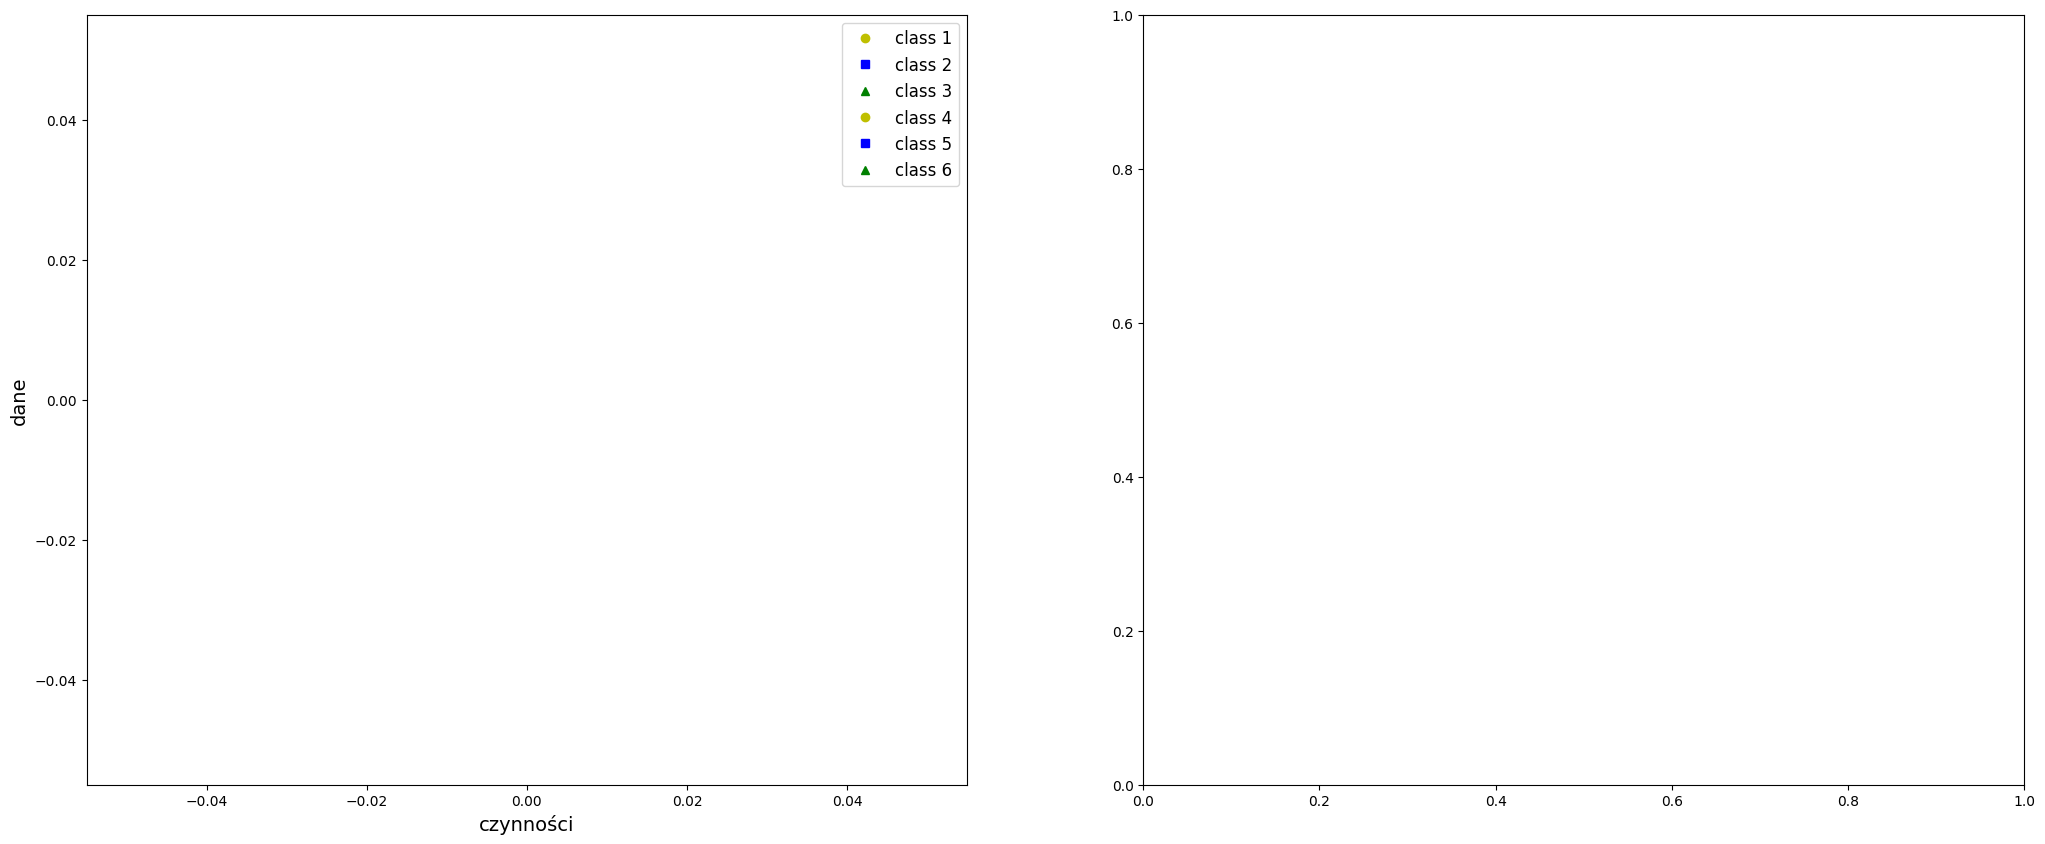

In [555]:
# przykład podziału dancyh w przypadku Supervised Learning oraz Clusteringu

plt.figure(figsize=(25, 10))

plt.subplot(121)
plt.plot(X[y==1, 0], X[y==1, 9], "yo", label="class 1")
plt.plot(X[y==2, 0], X[y==2, 9], "bs", label="class 2")
plt.plot(X[y==3, 0], X[y==3, 9], "g^", label="class 3")
plt.plot(X[y==4, 0], X[y==4, 9], "yo", label="class 4")
plt.plot(X[y==5, 0], X[y==5, 9], "bs", label="class 5")
plt.plot(X[y==6, 0], X[y==6, 9], "g^", label="class 6")
plt.xlabel("czynności", fontsize=14)
plt.ylabel("dane", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("czynności", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

In [ ]:
def plot_clusters(X, y=None):
    plt.figure(figsize=(15, 10))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15, rotation=0)
    plt.grid()

In [ ]:
plot_clusters(X)

InvalidIndexError: (slice(None, None, None), 0)

<Figure size 1500x1000 with 0 Axes>

In [ ]:
# import odpowiedniej biblioteki
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=6)

# możemy uzyć metod fit(), predict() 
clf.fit(X)
y_pred = clf.predict(X)

#albo metody fit/predict, która łączy dwie powyższe

y_pred = clf.fit_predict(X)
print(y_pred)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[1 4 4 ... 5 5 5]


In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(klasyfikator, X):
    # wyznaczanie granic decyzyjnych, podobnie jak w poprzednich notatnikach
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # rysowanie konturów granic 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    
    # rysowanie danych
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # centra klastrów można wyciągnąc za pomocą zmiennej cluster_centers_
    plot_centroids(klasyfikator.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [ ]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(clf, X)
plt.show()

ValueError: X has 2 features, but KMeans is expecting 922 features as input.

<Figure size 1000x500 with 0 Axes>

In [ ]:
clf.cluster_centers_

array([[-2.17241469e-03,  2.82224889e-01, -2.31879146e-02, ...,
        -4.96702523e-04,  1.67522747e-04,  1.16192481e-04],
       [-8.22051807e-04,  2.76921669e-01, -1.69806336e-02, ...,
        -2.84603070e-19,  1.35525272e-20,  6.77626358e-20],
       [-2.87258358e-03,  2.67314116e-01, -2.32079523e-02, ...,
        -8.13151629e-20, -2.37169225e-20,  2.71050543e-20],
       [-1.10579419e-04,  2.76497003e-01, -1.90194653e-02, ...,
        -2.57498016e-19,  0.00000000e+00,  6.09863722e-20],
       [-2.92272123e-04,  2.76873221e-01, -1.79957105e-02, ...,
         6.77626358e-20, -6.09863722e-20, -3.38813179e-21],
       [-1.13320003e-03,  2.70227518e-01, -2.36603601e-02, ...,
        -1.49077799e-19, -1.35525272e-20,  4.40457133e-20]])

In [ ]:
# poszczególne kroki 

clf_1 = KMeans(n_clusters=6, max_iter=1, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_2 = KMeans(n_clusters=6, max_iter=2, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_3 = KMeans(n_clusters=6, max_iter=3, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_300 = KMeans(n_clusters=6, max_iter=300, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_1.fit(X)
clf_2.fit(X)
clf_3.fit(X)
clf_300.fit(X)

KMeans(init='random', n_clusters=6, n_init=1, random_state=42)

ValueError: X has 2 features, but KMeans is expecting 922 features as input.

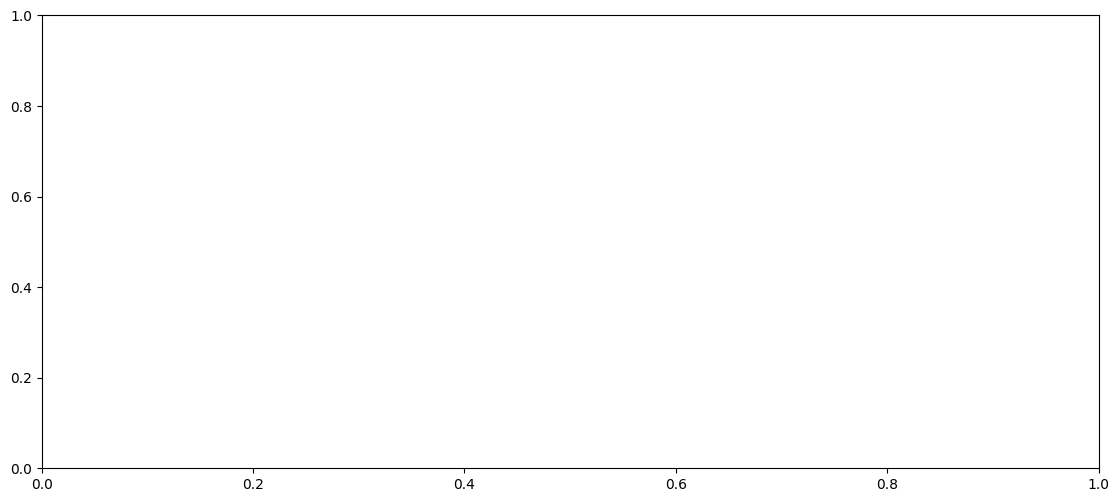

In [ ]:
# narysujmy teraz poszczególne kroki jeden pod drugim

plt.figure(figsize=(30, 20))

plt.subplot(321)
plot_decision_boundaries(clf_1, X)

plt.subplot(322)
plot_decision_boundaries(clf_2, X)

plt.subplot(323)
plot_decision_boundaries(clf_3, X)

plt.subplot(324)
plot_decision_boundaries(clf_300, X)
plt.show()

In [ ]:
# KMeans vs MiniBatchKMeans

# import odpowiedniej biblioteki
from sklearn.cluster import KMeans, MiniBatchKMeans

# K-means CLustering
from sklearn.cluster import MiniBatchKMeans

%timeit

# metoda MiniBatchKMeans
MBKMeans_clf = MiniBatchKMeans(n_clusters=5, max_iter=10, random_state=1)
%timeit MBKMeans_clf.fit(X)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `

167 ms ± 7.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


InvalidIndexError: (slice(None, None, None), 2)

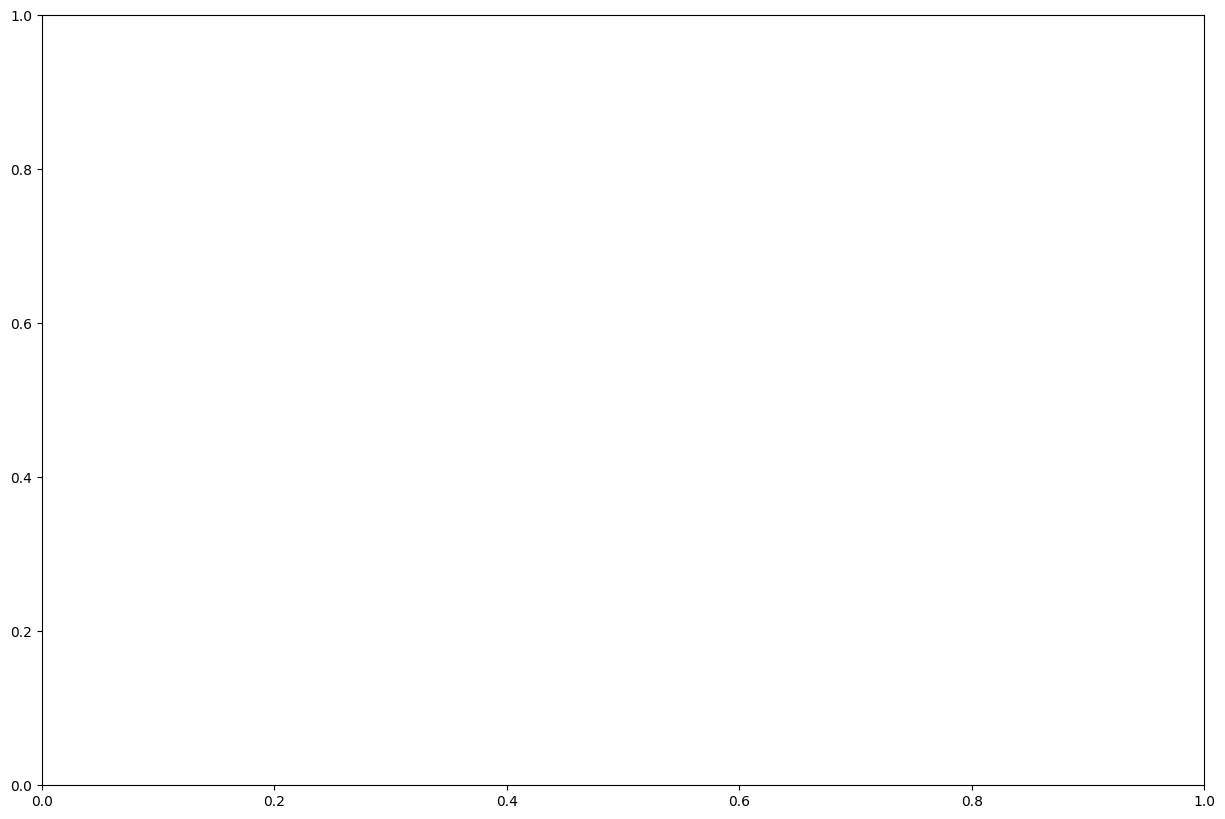

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot()
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("typy czynności", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

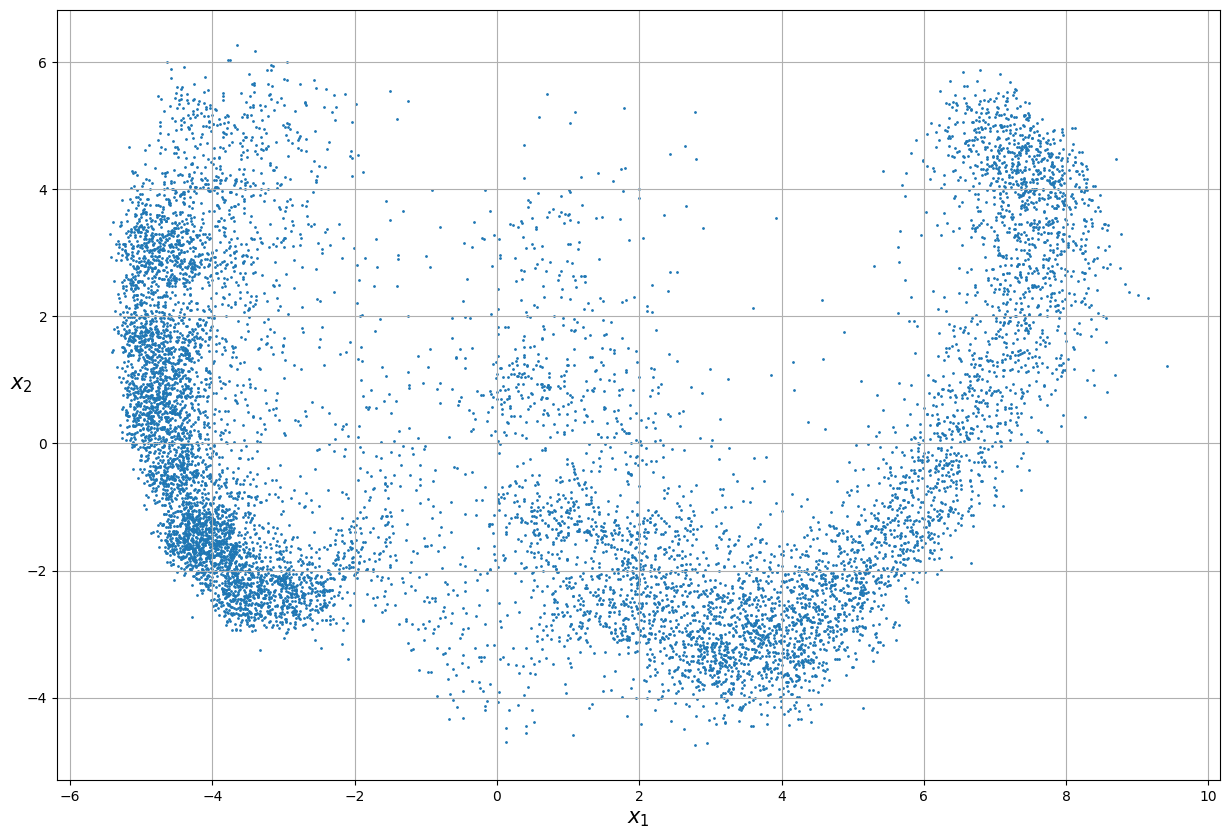

In [ ]:
def plot_clusters(X, y=None):
    plt.figure(figsize=(15, 10))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15, rotation=0)
    plt.grid()

plot_clusters(X)

In [ ]:
# import odpowiedniej biblioteki
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=6)

# możemy uzyć metod fit(), predict() 
clf.fit(X)
y_pred = clf.predict(X)

#albo metody fit/predict, która łączy dwie powyższe

y_pred = clf.fit_predict(X)
print(y_pred)

c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\magda\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 4 4 ... 1 2 2]


In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=3, linewidths=8,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(klasyfikator, X):
    # wyznaczanie granic decyzyjnych, podobnie jak w poprzednich notatnikach
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], 100),
                         np.linspace(mins[1], maxs[1], 100))
    Z = klasyfikator.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # rysowanie konturów granic 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    
    # rysowanie danych
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    # centra klastrów można wyciągnąc za pomocą zmiennej cluster_centers_
    plot_centroids(klasyfikator.cluster_centers_)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [ ]:
plt.figure(figsize=(10, 5))
plot_decision_boundaries(clf, X)
plt.show()

ValueError: X has 2 features, but KMeans is expecting 34 features as input.

<Figure size 1000x500 with 0 Axes>

In [ ]:
clf.cluster_centers_

array([[-8.76736387e-02, -5.19255771e-01, -5.42678918e-01,
        -5.43557400e-01, -5.42213167e-01, -5.45787947e-01,
        -5.47428313e-01, -5.38576256e-01, -5.40002940e-01,
        -5.28940155e-01, -5.19510566e-01, -5.14439184e-01,
        -5.11554805e-01, -4.90000719e-01, -4.58288393e-01,
        -4.75590329e-01, -4.64178088e-01, -4.82978779e-01,
        -4.76673478e-01, -5.13766125e-01, -5.42415553e-01,
        -5.50646380e-01, -5.77167817e-01, -5.95726480e-01,
        -6.24967122e-01, -6.39850795e-01, -6.69985279e-01,
        -6.96973612e-01, -7.23286856e-01, -7.25835953e-01,
        -6.92695844e-01, -6.32232707e-01, -5.37453573e-01,
        -5.25800895e-01, -5.27594446e-01, -5.27834213e-01,
        -5.25773412e-01, -5.28659470e-01, -5.28831093e-01,
        -5.28138627e-01, -5.26536862e-01, -5.31988845e-01,
        -5.28876075e-01, -5.24866717e-01, -5.27963101e-01,
        -5.18495548e-01, -5.10730019e-01, -5.03044437e-01,
        -4.95573613e-01, -4.82049127e-01, -4.72231997e-0

In [ ]:
# poszczególne kroki 

clf_1 = KMeans(n_clusters=5, max_iter=1, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_2 = KMeans(n_clusters=5, max_iter=2, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_3 = KMeans(n_clusters=5, max_iter=3, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_300 = KMeans(n_clusters=5, max_iter=300, init="random", n_init=1, algorithm="lloyd", random_state=42)
clf_1.fit(X)
clf_2.fit(X)
clf_3.fit(X)
clf_300.fit(X)

KMeans(init='random', n_clusters=5, n_init=1, random_state=42)

ValueError: X has 2 features, but KMeans is expecting 86 features as input.

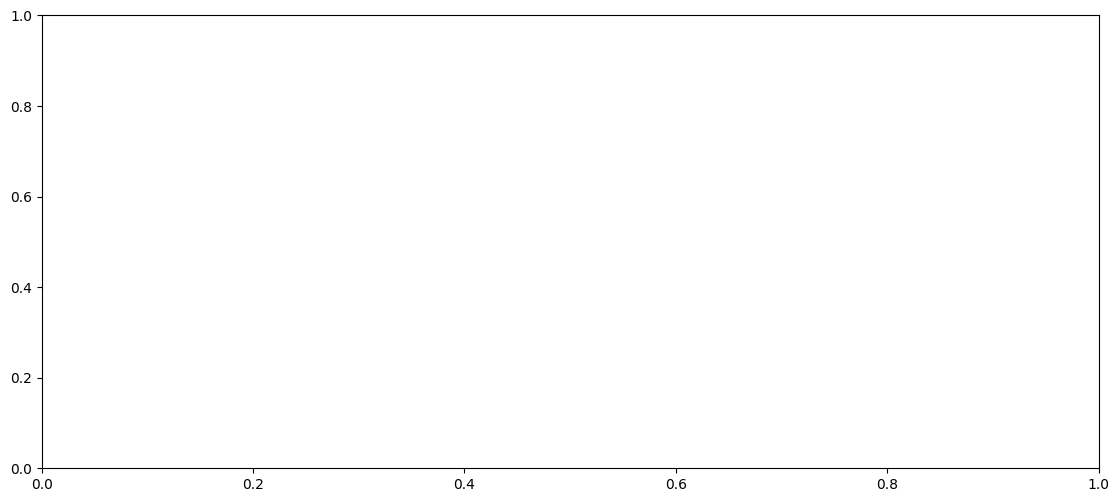

In [ ]:
# narysujmy teraz poszczególne kroki jeden pod drugim

plt.figure(figsize=(30, 20))

plt.subplot(321)
plot_decision_boundaries(clf_1, X)

plt.subplot(322)
plot_decision_boundaries(clf_2, X)

plt.subplot(323)
plot_decision_boundaries(clf_3, X)

plt.subplot(324)
plot_decision_boundaries(clf_300, X)
plt.show()

In [ ]:
# dataset.columns = range(dataset.columns.size)
# dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,913,914,915,916,917,918,919,920,921,922
0,NaN,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,NaN,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
2,NaN,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
3,NaN,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
4,NaN,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


<AxesSubplot: >

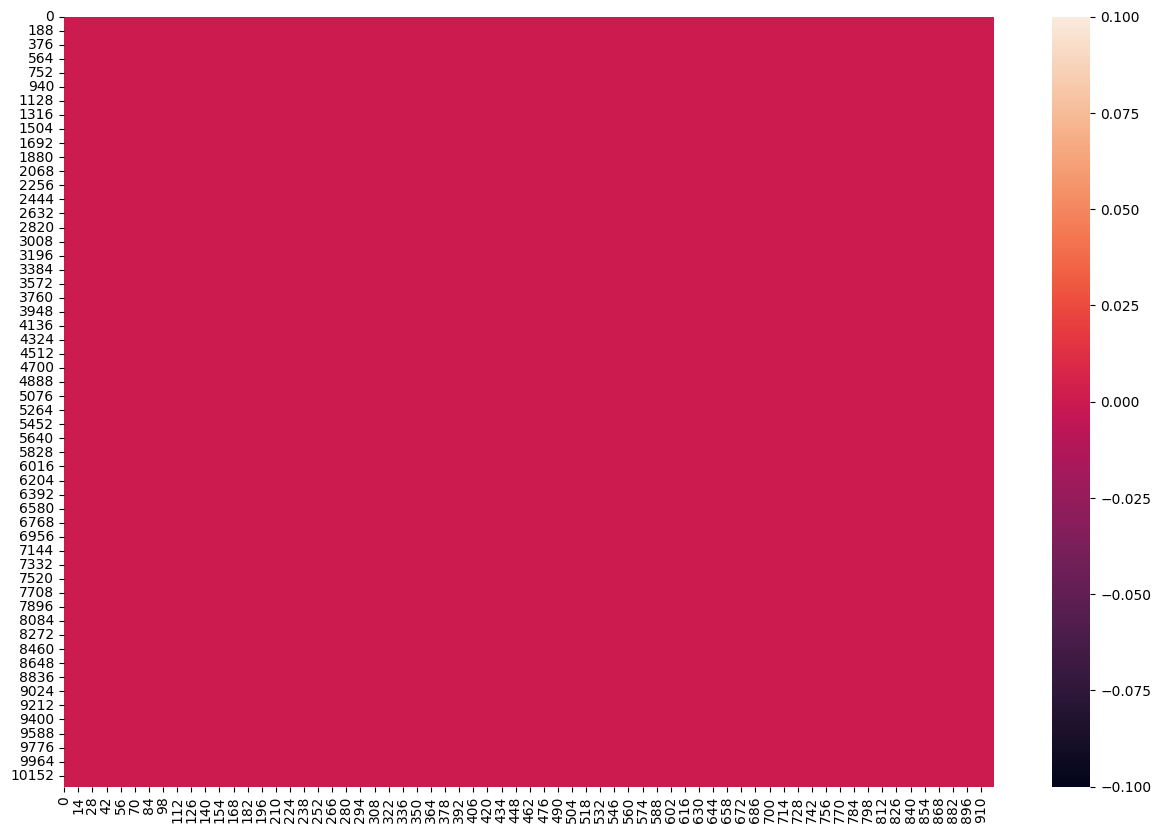

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(dataset.isnull())

In [ ]:
# dataset.fillna(0, inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10299 entries, 0 to 10298
Columns: 923 entries, 0 to target
dtypes: float64(922), int64(1)
memory usage: 72.5 MB


In [ ]:
from pandas import RangeIndex

features = RangeIndex(start=0, stop=86, step=1)
# target = 86
X, y = dataset[features], dataset['target']
print('X:')
display(X)
print('\ny:')
display(y)

X:


,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,0.899469,-0.970905,-0.975510,-0.984325,-0.988849,-0.917743,-1.000000,-1.000000,0.000000,0.113806
1,0.0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,-0.978500,-0.999188,-0.990029,-0.941685,-1.000000,-1.000000,-0.210494,-0.410056,0.000000,0.413856
2,0.0,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,-0.981672,-0.999679,-0.992104,-0.992619,-1.000000,-1.000000,-0.926776,0.000000,0.002234,0.000000
3,0.0,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,-0.969400,-0.982420,-0.995976,-0.980663,-0.979779,-1.000000,-1.000000,-0.596101,-0.064935,0.000000
4,0.0,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,-0.967051,-0.984363,-0.998318,-0.990611,-0.980412,-1.000000,-1.000000,-0.616578,-0.257267,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.0,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,...,0.000000,0.712964,-0.870515,-0.888599,-0.986121,-0.923034,-0.967281,-0.490470,-1.000000,-1.000000
10295,0.0,0.363385,-0.039214,-0.105915,-0.305388,0.000000,0.028148,-0.196373,-0.373540,-0.030036,...,0.713748,-0.872342,-0.891822,-0.986200,-0.933472,-0.945934,-0.497632,-1.000000,-1.000000,-0.496962
10296,0.0,0.349966,0.000000,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,...,0.712784,-0.871197,-0.893504,-0.987034,-0.943801,-0.974955,-0.550637,-1.000000,-1.000000,-0.518146
10297,0.0,0.237594,0.000000,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,...,-0.884788,-0.885275,-0.987011,-0.965473,-0.946943,-0.603068,-1.000000,-1.000000,-0.388504,0.000000



y:


0        5
1        5
2        5
3        5
4        5
        ..
10294    2
10295    2
10296    2
10297    2
10298    2
Name: target, Length: 10299, dtype: int64

In [ ]:
pd.Series(y).value_counts(normalize=True)

6    0.188756
5    0.185067
4    0.172541
1    0.167201
2    0.149917
3    0.136518
Name: target, dtype: float64

In [ ]:
from scipy import stats

corr_dict = {}
for col in features:
    corr_dict[col] = stats.pointbiserialr(X[col], y)[0]
pd.Series(corr_dict).sort_values(ascending=False)

0    -0.078431
85   -0.099239
84   -0.155204
83   -0.182715
82   -0.204620
        ...   
28   -0.519610
27   -0.531488
25   -0.532549
24   -0.534270
26   -0.541538
Length: 86, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

In [ ]:
from sklearn.model_selection import cross_val_score, cross_val_predict

# stworzenie klasyfikatora
clf = SGDClassifier(random_state=1)

# użycie metody cross_val_score do sprawdzenia
# działania naszego modelu na różnych podziałach
cv_score = cross_val_score(clf, X, y, cv=5)
print("wynik kroswalidacji: ", cv_score)
print("średni wynik wszystkich foldów: ", cv_score.mean())

wynik kroswalidacji:  [0.77669903 0.74320388 0.77718447 0.77864078 0.75910636]
średni wynik wszystkich foldów:  0.7669669035303215


In [ ]:
#Przykład podziału za pomocą stratyfikacji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                    random_state=3, stratify=y)
# summarize
train_1, train_2, train_3, train_4, train_5, train_6 = len(y_train[y_train==1]), len(y_train[y_train==2]), len(y_train[y_train==3]), len(y_train[y_train==4]), len(y_train[y_train==5]), len(y_train[y_train==6])
test_1, test_2, test_3, test_4, test_5, test_6 = len(y_test[y_test==1]), len(y_test[y_test==2]), len(y_test[y_test==3]), len(y_test[y_test==4]), len(y_test[y_test==5]), len(y_test[y_test==6])

print('>Train: 1=%d, 2=%d, 3=%d, 4=%d,5=%d, 6=%d, Test: 1=%d, 2=%d, 3=%d, 4=%d,5=%d, 6=%d' % (train_1, train_2, train_3, train_4, train_5, train_6, test_1, test_2, test_3, test_4, test_5, test_6))

>Train: 1=1378, 2=1235, 3=1125, 4=1421,5=1525, 6=1555, Test: 1=344, 2=309, 3=281, 4=356,5=381, 6=389


In [ ]:
def plot_clusters(X, y=None):
    plt.figure(figsize=(15, 10))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=15)
    plt.ylabel("$x_2$", fontsize=15, rotation=0)
    plt.grid()

In [ ]:
print('X:')
display(X)
print('\ny:')
display(y)

X:


,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,0.0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,0.899469,-0.970905,-0.975510,-0.984325,-0.988849,-0.917743,-1.000000,-1.000000,0.000000,0.113806
1,0.0,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,-0.978500,-0.999188,-0.990029,-0.941685,-1.000000,-1.000000,-0.210494,-0.410056,0.000000,0.413856
2,0.0,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,-0.981672,-0.999679,-0.992104,-0.992619,-1.000000,-1.000000,-0.926776,0.000000,0.002234,0.000000
3,0.0,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,-0.969400,-0.982420,-0.995976,-0.980663,-0.979779,-1.000000,-1.000000,-0.596101,-0.064935,0.000000
4,0.0,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,-0.967051,-0.984363,-0.998318,-0.990611,-0.980412,-1.000000,-1.000000,-0.616578,-0.257267,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.0,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,...,0.000000,0.712964,-0.870515,-0.888599,-0.986121,-0.923034,-0.967281,-0.490470,-1.000000,-1.000000
10295,0.0,0.363385,-0.039214,-0.105915,-0.305388,0.000000,0.028148,-0.196373,-0.373540,-0.030036,...,0.713748,-0.872342,-0.891822,-0.986200,-0.933472,-0.945934,-0.497632,-1.000000,-1.000000,-0.496962
10296,0.0,0.349966,0.000000,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,...,0.712784,-0.871197,-0.893504,-0.987034,-0.943801,-0.974955,-0.550637,-1.000000,-1.000000,-0.518146
10297,0.0,0.237594,0.000000,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,...,-0.884788,-0.885275,-0.987011,-0.965473,-0.946943,-0.603068,-1.000000,-1.000000,-0.388504,0.000000



y:


0        5
1        5
2        5
3        5
4        5
        ..
10294    2
10295    2
10296    2
10297    2
10298    2
Name: target, Length: 10299, dtype: int64

In [ ]:
plot_clusters(X)

InvalidIndexError: (slice(None, None, None), 0)

<Figure size 1500x1000 with 0 Axes>